# IMPORT MODULE

In [1]:
ls

README.md                               datasets.csv
TravelTime_451.csv                      machine_temperature_system_failure.csv
Twitter_volume_UPS.csv                  main2.ipynb
Untitled-1.ipynb                        nyc_taxi.csv
ambient_temperature_system_failure.csv  requirements.txt
cpu.csv                                 timeeval.log


In [2]:
!pip install -r requirements.txt
!pip install prophet
!pip install seaborn
!pip install keras
!pip install tensorflow

In [4]:
import pandas as pd
import requests
from io import StringIO
import numpy as np 
import matplotlib.pyplot as plt
import adtk
from  adtk.data import validate_series
import matplotlib.style
%matplotlib inline
import kneed 
from sklearn.neighbors import LocalOutlierFactor
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet
import sklearn 
from sklearn.metrics import mean_absolute_error , mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import keras
from sklearn.metrics import confusion_matrix
import seaborn as sns
from scipy.stats import median_abs_deviation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from adtk.detector import ThresholdAD
from adtk.detector import QuantileAD
from adtk.detector import InterQuartileRangeAD

---

# IMPORT DATA SET

We will evaluate our models on the basis of different time series. The explination of this data set will be presented in the rapport

In [5]:
def importdataset(file):
    dataset = pd.read_csv(file)
    return dataset

In [6]:
cpu_data = importdataset("cpu.csv")
twitter_data = importdataset("Twitter_volume_UPS.csv")
taxi_data = importdataset("nyc_taxi.csv")
machine_data = importdataset("machine_temperature_system_failure.csv")
ambiant_data = importdataset("ambient_temperature_system_failure.csv")
travel_data = importdataset("TravelTime_451.csv")

In [7]:
anomalies_cpu = [
        "2014-02-26 22:05:00",
        "2014-02-27 17:15:00"
    ]

anomalies_ambiant = [
        "2013-12-22 20:00:00",
        "2014-04-13 09:00:00"
    ]

anomalie_machine = [
        "2013-12-11 06:00:00",
        "2013-12-16 17:25:00",
        "2014-01-28 13:55:00",
        "2014-02-08 14:30:00"
    ]


anomalie_taxi = [
            "2014-10-30 15:30:00",
            "2014-11-03 22:30:00",
            "2014-11-25 12:00:00",
            "2014-11-29 19:00:00",
            "2014-12-23 11:30:00",
            "2014-12-27 18:30:00",
            "2014-12-29 21:30:00",
            "2015-01-03 04:30:00",
            "2015-01-24 20:30:00",
            "2015-01-29 03:30:00"
        ]


anomalie__twitter =  [
        "2015-03-03 00:27:53",
        "2015-03-04 11:07:53",
        "2015-03-05 15:22:53",
        "2015-03-24 18:17:53",
        "2015-03-29 16:27:53"
    ]

anomalie_traval = [
    "2015-08-11 21:32:00.000000"
    ]


---

# Pre processing

In [8]:
def timestamp(df):   #Transform the data set in order to have a correct timestamp by transofrming the / into -
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df


In [9]:
def label(df, anomalies_timestamp):
    # Initially set all rows to non-anomaly
    df['is_anomaly'] = 1

    # Loop through each anomaly timestamp
    for each in anomalies_timestamp:
        # Use .loc for proper conditional indexing
        df.loc[df['timestamp'] == each, 'is_anomaly'] = -1
    
    return df

---

# Vizualisation

In [10]:
def visualisation(df):
    anomaly_df = df[df['is_anomaly'] == -1]
    inlier_df = df[df['is_anomaly'] == 1]
    fig, ax = plt.subplots()

    ax.scatter(inlier_df['timestamp'], inlier_df['value'], color='blue', s=3, label='Inlier')
    ax.scatter(anomaly_df['timestamp'], anomaly_df['value'], color='red', label='Anomaly')
    ax.set_xlabel('Time')

    ax.legend(loc=2)

    plt.grid(False)
    fig.autofmt_xdate()
    plt.tight_layout()

---

# Stationarity Hypothesis 

One key element that is often used when dealing with time series is the stationarity hypothesis

In [11]:
def is_time_series_stationary(df):
    # Perform Dickey-Fuller test:
    result = adfuller(df['value'])
    adf_statistic = result[0]
    p_value = result[1]
    if p_value < 0.05:
            return True
    else:
        return False

---

# Specific Data Set

Some algorithms such as ATDK and LSTM requires a specific format of the data. Indeed to work in the univariate case. The data should be a in serie format where the timestamp is the index

In [12]:
def serie(df):
    new_df = df.copy()
    new_df = new_df.set_index('timestamp')
    columns_to_drop = [col for col in new_df.columns if col != 'value']
    new_df = new_df.drop(columns=columns_to_drop)
    return new_df

---

# MODELS

---

# LSTM

In [13]:
def train_test(df):
    train_size = int(len(df) * 0.95)
    train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
    return(train, test)

In [14]:
def standard(train, test):
    scaler = StandardScaler()
    scaler = scaler.fit(train[['value']])

    # Use .loc to avoid SettingWithCopyWarning
    train.loc[:, 'value'] = scaler.transform(train[['value']])
    test.loc[:, 'value'] = scaler.transform(test[['value']])

    return train, test

In [15]:
def create_dataset(X, y, time_steps=30):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [16]:
def create_and_train_lstm_model(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, shuffle=False):
    """
    Create and train an LSTM model using the given training data.

    Parameters:
    X_train (np.array): Input features for training.
    y_train (np.array): Target values for training.
    epochs (int): Number of epochs to train the model.
    batch_size (int): Batch size for training.
    validation_split (float): Fraction of the training data to be used as validation data.
    shuffle (bool): Whether to shuffle the training data before each epoch.

    Returns:
    keras.models.Sequential: The trained LSTM model.
    keras.callbacks.History: Training history object.
    """
    # Create the LSTM model
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units=64, input_shape=input_shape))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.RepeatVector(n=input_shape[0]))
    model.add(keras.layers.LSTM(units=64, return_sequences=True))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=input_shape[1])))
    model.compile(loss='mae', optimizer='adam')

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        shuffle=shuffle
    )

    return model, history


In [17]:
def detect_anomalies_and_plot(X_test, model, test_df, TIME_STEPS, threshold=0.65):
   
    # Predict on X_test
    X_test_pred = model.predict(X_test)

    # Calculate MAE loss
    test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

    # Create a DataFrame for the test score
    test_score_df = pd.DataFrame(index=test_df[TIME_STEPS:].index)
    test_score_df['loss'] = test_mae_loss
    test_score_df['threshold'] = threshold
    test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
    test_score_df['close'] = test_df[TIME_STEPS:].close

    # Plotting
    plt.plot(test_score_df.index, test_score_df.loss, label='loss')
    plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
    plt.xticks(rotation=25)
    plt.legend()
    plt.show()

    return test_score_df

In [18]:
def detect_anomalies(X_test, model, test_df, TIME_STEPS, threshold=0.65):
    # Predict on X_test
    X_test_pred = model.predict(X_test)

    # Calculate MAE loss
    test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

    # Create a DataFrame for the test score
    test_score_df = pd.DataFrame(index=test_df[TIME_STEPS:].index)
    test_score_df['loss'] = test_mae_loss
    test_score_df['threshold'] = threshold
    test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
    test_score_df['value'] = test_df[TIME_STEPS:].value

    # Update 'anomaly' column to have 1 for anomalies and -1 for normal points
    test_score_df['anomaly'] = test_score_df['anomaly'].apply(lambda x: -1 if x else 1)

    # Return the test score DataFrame
    return test_score_df


In [19]:
def plot_loss(test_score_df):
    plt.plot(test_score_df.index, test_score_df.loss, label='loss')
    plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
    plt.xticks(rotation=25)
    plt.legend()
    plt.show()


In [20]:
def mark_ground_truth(df, anomalies):
    # Convert anomalies list to a set for faster lookup
    anomalies_set = set(anomalies)

    # Create 'ground_truth' column, -1 for anomalies, 1 for normal data
    df['ground_truth'] = df.index.map(lambda x: -1 if x in anomalies_set else 1)

    return df


In [62]:
def print_confusion_matrix_metrics_lm(df):
    # Extract ground_truth and anomaly columns
    y_true = df['ground_truth']
    y_pred = df['anomaly']

    # Calculate confusion matrix
    confusion_mat = confusion_matrix(y_true, y_pred, labels=[1, -1])
    TN, FP, FN, TP = confusion_mat.ravel()

    # Calculate recall (sensitivity)
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0

    # Calculate specificity
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

    # Print the results
    print("Confusion Matrix:")
    print(f"True Negatives (TN): {TN}")
    print(f"False Positives (FP): {FP}")
    print(f"False Negatives (FN): {FN}")
    print(f"True Positives (TP): {TP}")
    print(f"Recall (Sensitivity): {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")

    # Plot confusion matrix
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", 
                xticklabels=[1, -1], yticklabels=[1, -1])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()



---

# MAD

In [22]:
def isnormal(df):

    sns.kdeplot(df['value']);
    plt.grid(False)
    plt.axvline(0.134, 0, 1, c='black', ls='--')
    plt.tight_layout()

In [23]:
def add_robust_z_score_column(data):
    # Calculate the median of the column
    df = data.copy()
    median = df['value'].median()

    # Calculate the Median Absolute Deviation (MAD)
    mad = np.median(np.abs(df['value'] - median))

    # Calculate the robust Z-score and add it as a new column
    df['z-score'] = 0.6745 * (df['value'] - median) / mad if mad else 0

    return df


In [24]:
def anomaly_predicted(df):
    # Initialize 'anomaly_predicted' to 1 (normal) for all rows
    df['anomaly_predicted'] = 1

    # Mark as -1 (anomaly) where z-score is >= 3.5 or <= -3.5
    df.loc[df['z-score'] >= 3.5, 'anomaly_predicted'] = -1
    df.loc[df['z-score'] <= -3.5, 'anomaly_predicted'] = -1

    return df

In [25]:
def confusion_metrics(df):
    # Extract ground_truth and anomaly columns
    y_true = df['is_anomaly']
    y_pred = df['anomaly_predicted']

    # Calculate confusion matrix
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()

    # Calculate recall (sensitivity)
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0

    # Calculate specificity
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

    # Print the results
    print("Confusion Matrix:")
    print(f"True Negatives (TN): {TN}")
    print(f"False Positives (FP): {FP}")
    print(f"False Negatives (FN): {FN}")
    print(f"True Positives (TP): {TP}")
    print(f"Recall (Sensitivity): {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")

In [26]:
def plot_confusion_matrix(df):
    # Compute the confusion matrix
    cm = confusion_matrix(df['is_anomaly'], df['anomaly_predicted'], labels=[1, -1])

    # Create the confusion matrix display object
    disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])

    # Plot the confusion matrix
    disp_cm.plot()
    plt.grid(False)
    plt.tight_layout()
    plt.show()


---

# Isolation Forest

In [27]:
def createisolation(train, test , contamination):
    # Splitting the data into train and test sets

    # Extracting the 'value' column for training
    X_train = train['value'].values.reshape(-1, 1)

    # Creating the Isolation Forest model
    iso_forest = IsolationForest(contamination=contamination, random_state=42)

    # Fitting the model
    iso_forest.fit(X_train)

    # Predicting anomalies on the test set
    result = iso_forest.predict(test['value'].values.reshape(-1, 1))

    # Returning the test set and the result for further processing
    return  result

In [29]:
def confusion_metrics_iso(test, result):
    # Extract ground_truth and anomaly columns
    y_true = test['is_anomaly']
    y_pred = result

    # Calculate confusion matrix
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()

    # Calculate recall (sensitivity)
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0

    # Calculate specificity
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

    # Print the results
    print("Confusion Matrix:")
    print(f"True Negatives (TN): {TN}")
    print(f"False Positives (FP): {FP}")
    print(f"False Negatives (FN): {FN}")
    print(f"True Positives (TP): {TP}")
    print(f"Recall (Sensitivity): {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")

In [30]:
def plot_confusion_matrix_iso(df , result):
    # Compute the confusion matrix
    cm = confusion_matrix(df['is_anomaly'], result, labels=[1, -1])

    # Create the confusion matrix display object
    disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])

    # Plot the confusion matrix
    disp_cm.plot()
    plt.grid(False)
    plt.tight_layout()
    plt.show()


---



# LocalOutlierFactor

In [31]:
def compute_confusion_matrix_local(train, test, contamination):
    lof = LocalOutlierFactor(contamination=contamination, novelty=True)
    X_train = train['value'].values.reshape(-1, 1)
    lof.fit(X_train)

    X_test = test['value'].values.reshape(-1, 1)
    preds_lof = lof.predict(X_test)

    # Adjust predictions to match labels (if necessary)
    preds_lof = [-1 if p == -1 else 1 for p in preds_lof]

    cm = confusion_matrix(test['is_anomaly'], preds_lof, labels=[1, -1])
    return cm

In [32]:
def display_confusion_matrix_local(cm):
    disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])
    disp_cm.plot()
    plt.grid(False)
    plt.tight_layout()
    plt.show()

In [33]:
def print_confusion_matrix_metrics_local(cm):
    TN, FP, FN, TP = cm.ravel()

    # Calculate recall (sensitivity) and specificity
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

    # Print the results
    print("Confusion Matrix Metrics:")
    print(f"True Negatives (TN): {TN}")
    print(f"False Positives (FP): {FP}")
    print(f"False Negatives (FN): {FN}")
    print(f"True Positives (TP): {TP}")
    print(f"Recall (Sensitivity): {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")


# ADTK

We use a histogram in order to have the right threeshold 

In [34]:
def histogram(series):
   
    plt.hist(series, bins=20, edgecolor='black')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Distribution of Series Values')
    plt.grid(True)
    plt.show()


In [35]:
def convert(L):
    T = []
    for i in range(len(L)):
        if L[i] == False:
            T.append(1)
        else:
            T.append(-1)
    return T

---

# PROPHET

In [121]:
def datasetprophet(df):
    Prophet_data = df.copy()
    Prophet_data['ds'] = df['timestamp']
    Prophet_data['y'] = df['value']
    Prophet_data = Prophet_data.drop(['timestamp', 'value', 'is_anomaly'] , axis =1)
    return Prophet_data


In [38]:
def model(df):
    model = Prophet(interval_width = 0.99 , yearly_seasonality = False , weekly_seasonality = False)
    model.fit(df)
    return model

In [37]:
def forecast(df,model):
    forecast = model.predict(df)
    model.plot(forecast)

In [39]:
def evaluation(df,model):
    forecast = model.predict(df)
    performance = pd.merge(df, forecast[['ds' ,'yhat' ,'yhat_lower' ,'yhat_upper']], on = 'ds')
    performance_MAE = mean_absolute_error(performance['y'], performance['yhat'])
    performance_MAPE = mean_absolute_percentage_error(performance['y'], performance['yhat'])
    performance['anomaly_predicted'] = performance.apply(lambda rows : -1 if ((rows.y <rows.yhat_lower)  | (rows.y > rows.yhat_upper) ) else 1 , axis =1)
    print(f"MAE is equal to  {performance_MAE} ")
    print(f"MAPE is equal to  {performance_MAPE} ")
    return performance 
 

---

---

---

# STUDY CASE

---

---

---

# CPU DATA SET

Obtention of the data set

In [40]:
cpu_data = importdataset("cpu.csv")


Pré-traitement

In [41]:
cpu_data = timestamp(cpu_data)

In [42]:
cpu_data = label(cpu_data, anomalies_cpu)

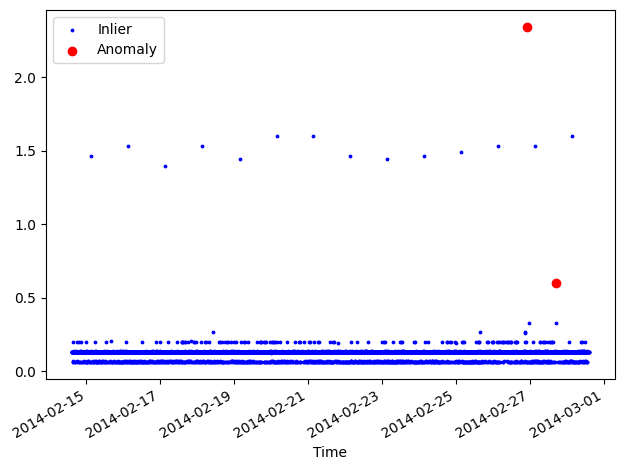

In [43]:
visualisation(cpu_data)


In [44]:
print(f"is the machine failure data set stationnary ? Answer : {is_time_series_stationary(machine_data)}.") 
print(f"is the ambiant failure data set stationnary ? Answer : {is_time_series_stationary(ambiant_data)}.") 
print(f"is the travel data set stationnary ? Answer : {is_time_series_stationary(travel_data)}.") 
print(f"is the CPU data set stationnary ? Answer : {is_time_series_stationary(cpu_data)}.") 
print(f"is the taxi data set stationnary ? Answer : {is_time_series_stationary(taxi_data)}.") 
print(f"is the twitter data set stationnary ? Answer : {is_time_series_stationary(twitter_data)}.") 

is the machine failure data set stationnary ? Answer : True.
is the ambiant failure data set stationnary ? Answer : True.
is the travel data set stationnary ? Answer : True.
is the CPU data set stationnary ? Answer : True.
is the taxi data set stationnary ? Answer : True.
is the twitter data set stationnary ? Answer : True.


---

# LSTM 

We apply the LSTM to the CPU dataset with 10 epocs

In [45]:
new_df = cpu_data.copy()
new_df = new_df.set_index('timestamp')

In [46]:
serie_cpu = serie(cpu_data)

In [47]:
train_cpu , test_cpu = train_test(serie_cpu)

In [48]:
train_standard_cpu , test_standard_cpu = standard(train_cpu , test_cpu)

In [135]:
X_train_cpu, y_train_cpu = create_dataset(train_standard_cpu[['value']], train_standard_cpu.value, 24)
X_test_cpu, y_test_cpu = create_dataset(test_standard_cpu[['value']], test_standard_cpu.value, 24)

With a 10 epoch

In [136]:
model = create_and_train_lstm_model(X_train_cpu, y_train_cpu, epochs=10, batch_size=32, validation_split=0.1, shuffle=False)

Epoch 1/10
108/108 [==============================] - 3s 13ms/step - loss: 0.2490 - val_loss: 0.3221
Epoch 2/10
108/108 [==============================] - 1s 10ms/step - loss: 0.2460 - val_loss: 0.3214
Epoch 3/10
108/108 [==============================] - 1s 10ms/step - loss: 0.2456 - val_loss: 0.3211
Epoch 4/10
108/108 [==============================] - 1s 10ms/step - loss: 0.2455 - val_loss: 0.3207
Epoch 5/10
108/108 [==============================] - 1s 10ms/step - loss: 0.2453 - val_loss: 0.3205
Epoch 6/10
108/108 [==============================] - 1s 10ms/step - loss: 0.2451 - val_loss: 0.3204
Epoch 7/10
108/108 [==============================] - 1s 10ms/step - loss: 0.2451 - val_loss: 0.3203
Epoch 8/10
108/108 [==============================] - 1s 10ms/step - loss: 0.2450 - val_loss: 0.3202
Epoch 9/10
108/108 [==============================] - 1s 10ms/step - loss: 0.2449 - val_loss: 0.3202
Epoch 10/10
108/108 [==============================] - 1s 10ms/step - loss: 0.2449 - val_lo

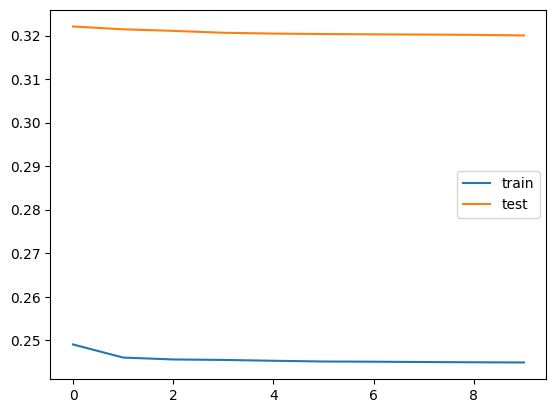

In [137]:
plt.plot(model[1].history['loss'], label='train')
plt.plot(model[1].history['val_loss'], label='test')
plt.legend();

In [138]:
test_score_df = detect_anomalies(X_test_cpu, model[0], test_standard_cpu, 24, threshold=0.65)

6/6 [==============================] - 0s 4ms/step


178

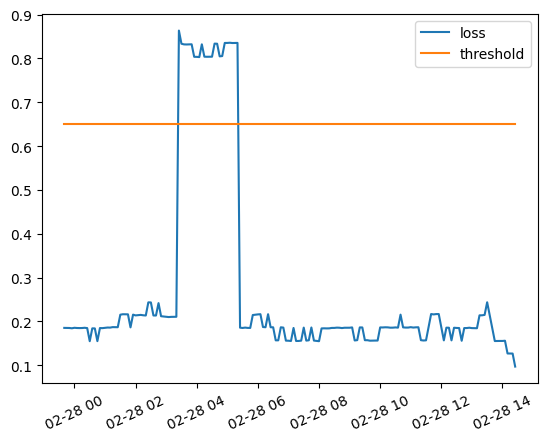

In [139]:
plot_loss(test_score_df)

In [140]:
df_with_ground_truth_cpu = mark_ground_truth(test_score_df, anomalies_cpu)

Confusion Matrix:
True Negatives (TN): 154
False Positives (FP): 24
False Negatives (FN): 0
True Positives (TP): 0
Recall (Sensitivity): 0.00
Specificity: 0.87


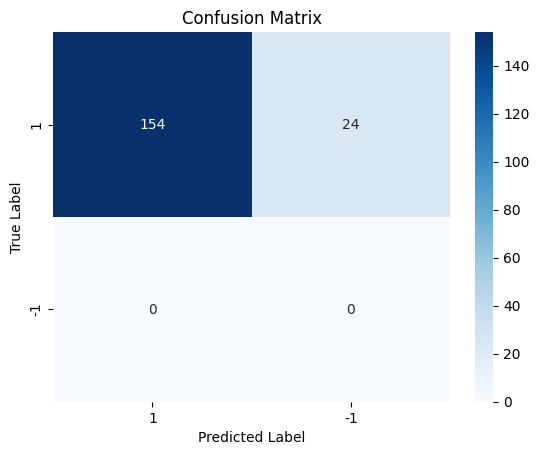

In [141]:
print_confusion_matrix_metrics_lm(df_with_ground_truth_cpu)

In [142]:
model_1 = create_and_train_lstm_model(X_train_cpu, y_train_cpu, epochs=100, batch_size=32, validation_split=0.1, shuffle=False)

Epoch 1/100
108/108 [==============================] - 3s 13ms/step - loss: 0.2494 - val_loss: 0.3227
Epoch 2/100
108/108 [==============================] - 1s 11ms/step - loss: 0.2462 - val_loss: 0.3216
Epoch 3/100
108/108 [==============================] - 1s 10ms/step - loss: 0.2456 - val_loss: 0.3212
Epoch 4/100
108/108 [==============================] - 1s 10ms/step - loss: 0.2454 - val_loss: 0.3207
Epoch 5/100
108/108 [==============================] - 1s 10ms/step - loss: 0.2453 - val_loss: 0.3207
Epoch 6/100
108/108 [==============================] - 1s 11ms/step - loss: 0.2452 - val_loss: 0.3205
Epoch 7/100
108/108 [==============================] - 1s 11ms/step - loss: 0.2451 - val_loss: 0.3204
Epoch 8/100
108/108 [==============================] - 1s 10ms/step - loss: 0.2450 - val_loss: 0.3203
Epoch 9/100
108/108 [==============================] - 1s 10ms/step - loss: 0.2450 - val_loss: 0.3203
Epoch 10/100
108/108 [==============================] - 1s 10ms/step - loss: 0.244

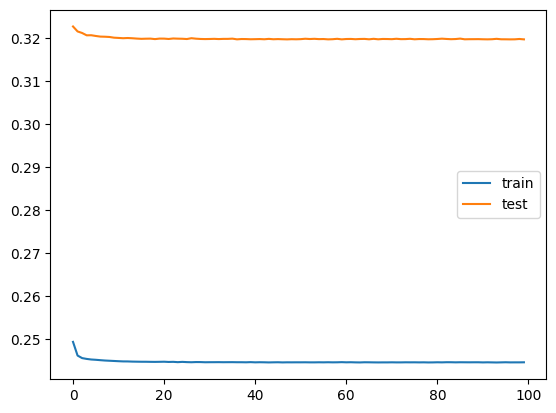

In [143]:
plt.plot(model_1[1].history['loss'], label='train')
plt.plot(model_1[1].history['val_loss'], label='test')
plt.legend();

In [144]:
test_score_df_1 = detect_anomalies(X_test_cpu, model_1[0], test_standard_cpu, 24, threshold=0.65)

6/6 [==============================] - 0s 3ms/step


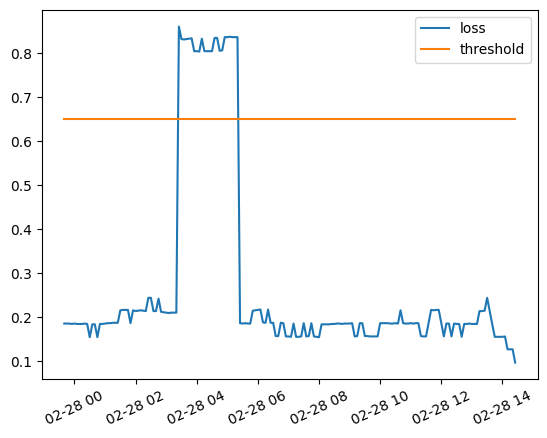

In [145]:
plot_loss(test_score_df_1)

In [146]:
df_with_ground_truth_cpu_1 = mark_ground_truth(test_score_df_1, anomalies_cpu)

Confusion Matrix:
True Negatives (TN): 154
False Positives (FP): 24
False Negatives (FN): 0
True Positives (TP): 0
Recall (Sensitivity): 0.00
Specificity: 0.87


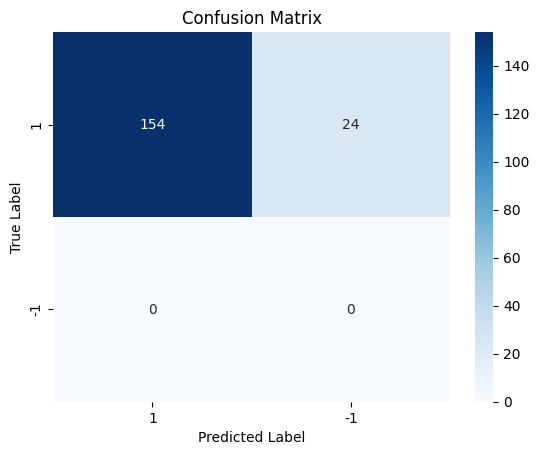

In [147]:
print_confusion_matrix_metrics_lm(df_with_ground_truth_cpu_1)

---

# MAD

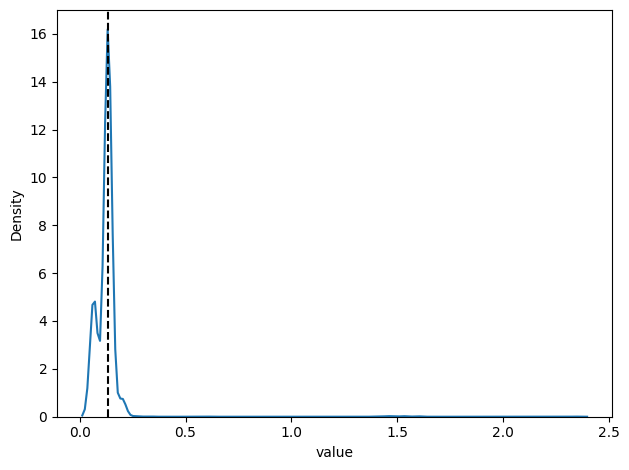

In [70]:
isnormal(cpu_data)

In [71]:
MAD_cpu_data_set =add_robust_z_score_column(cpu_data)

In [72]:
anomaly_predicted(MAD_cpu_data_set)

,timestamp,value,is_anomaly,z-score,anomaly_predicted
0,2014-02-14 14:30:00,0.132,1,-0.6745,1
1,2014-02-14 14:35:00,0.134,1,0.0000,1
2,2014-02-14 14:40:00,0.134,1,0.0000,1
3,2014-02-14 14:45:00,0.134,1,0.0000,1
4,2014-02-14 14:50:00,0.134,1,0.0000,1
...,...,...,...,...,...
4027,2014-02-28 14:05:00,0.132,1,-0.6745,1
4028,2014-02-28 14:10:00,0.134,1,0.0000,1
4029,2014-02-28 14:15:00,0.134,1,0.0000,1
4030,2014-02-28 14:20:00,0.134,1,0.0000,1


Confusion Matrix:
True Negatives (TN): 2
False Positives (FP): 0
False Negatives (FN): 1066
True Positives (TP): 2964
Recall (Sensitivity): 0.74
Specificity: 1.00


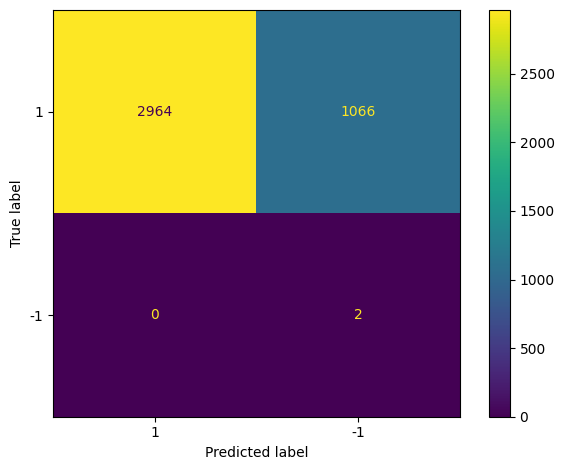

In [73]:
confusion_metrics(anomaly_predicted(MAD_cpu_data_set))
plot_confusion_matrix(anomaly_predicted(MAD_cpu_data_set))

---

# Isoltation forest

In [74]:
train_iso , test_iso = train_test_split(cpu_data, test_size=0.2, random_state=42)

Contamination level: 0.5
Confusion Matrix:
True Negatives (TN): 0
False Positives (FP): 0
False Negatives (FN): 238
True Positives (TP): 569
Recall (Sensitivity): 0.71
Specificity: 0.00


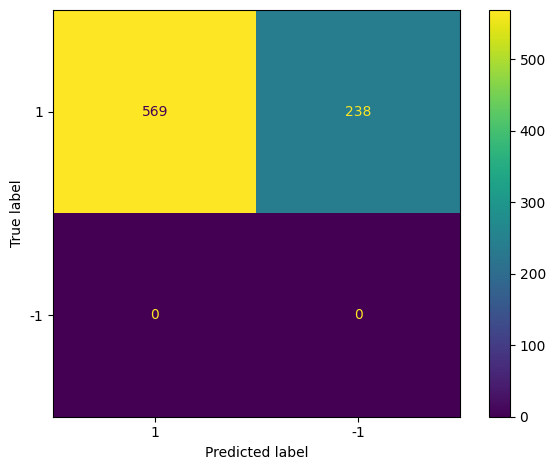

Contamination level: 0.05
Confusion Matrix:
True Negatives (TN): 0
False Positives (FP): 0
False Negatives (FN): 37
True Positives (TP): 770
Recall (Sensitivity): 0.95
Specificity: 0.00


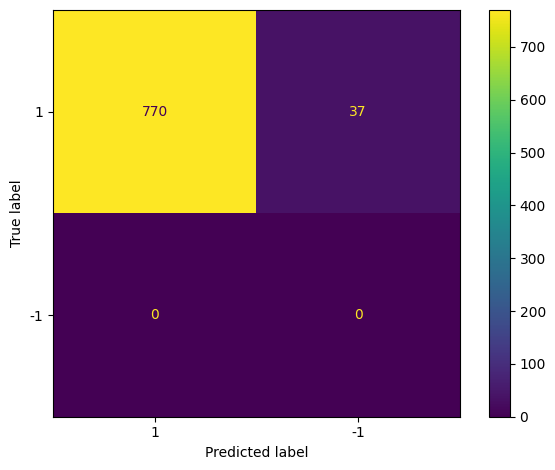

Contamination level: 0.005
Confusion Matrix:
True Negatives (TN): 0
False Positives (FP): 0
False Negatives (FN): 9
True Positives (TP): 798
Recall (Sensitivity): 0.99
Specificity: 0.00


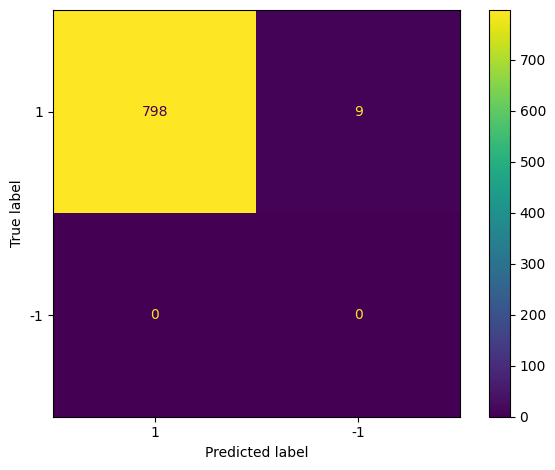

In [75]:
i = 0.5
while i >= 0.001:
    # Create isolation with the current contamination level
    prediction_result = createisolation(train_iso, test_iso, i)

    # Print metrics and plot confusion matrix
    print(f"Contamination level: {i}")
    confusion_metrics_iso(test_iso, prediction_result)
    plot_confusion_matrix_iso(test_iso, prediction_result)

    # Divide i by 10 for the next iteration
    i /= 10


---

# LOCAL OUTLIER FACTOR

Contamination level: 0.5


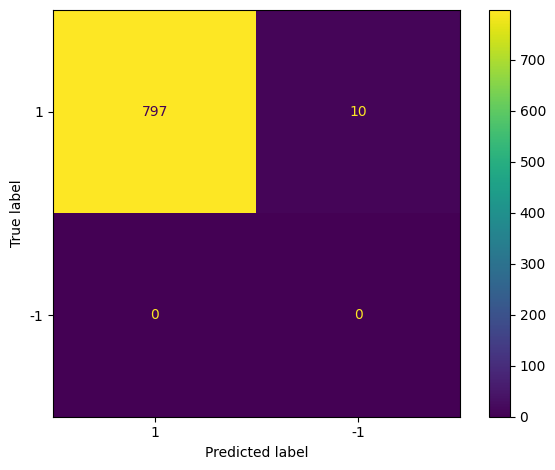

Confusion Matrix Metrics:
True Negatives (TN): 797
False Positives (FP): 10
False Negatives (FN): 0
True Positives (TP): 0
Recall (Sensitivity): 0.00
Specificity: 0.99
Contamination level: 0.05


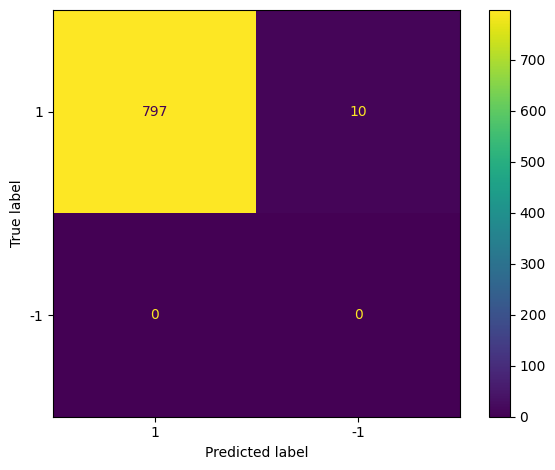

Confusion Matrix Metrics:
True Negatives (TN): 797
False Positives (FP): 10
False Negatives (FN): 0
True Positives (TP): 0
Recall (Sensitivity): 0.00
Specificity: 0.99
Contamination level: 0.005


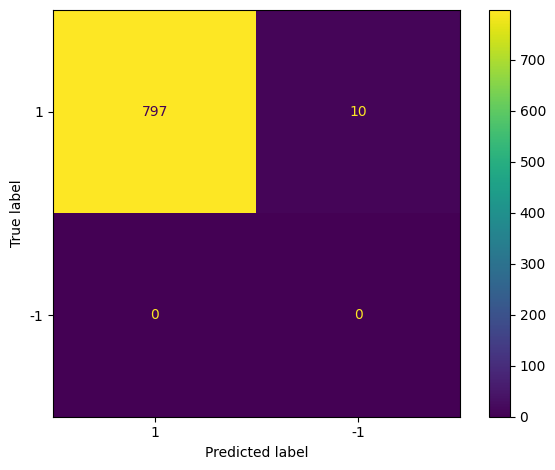

Confusion Matrix Metrics:
True Negatives (TN): 797
False Positives (FP): 10
False Negatives (FN): 0
True Positives (TP): 0
Recall (Sensitivity): 0.00
Specificity: 0.99


In [76]:
i = 0.5
while i >= 0.001:
    # Create isolation with the current contamination level
    cm = compute_confusion_matrix_local(train_iso , test_iso , i)

    # Print metrics and plot confusion matrix
    print(f"Contamination level: {i}")
    display_confusion_matrix_local(cm)
    print_confusion_matrix_metrics_local(cm)

    # Divide i by 10 for the next iteration
    i /= 10

---

# ATDK

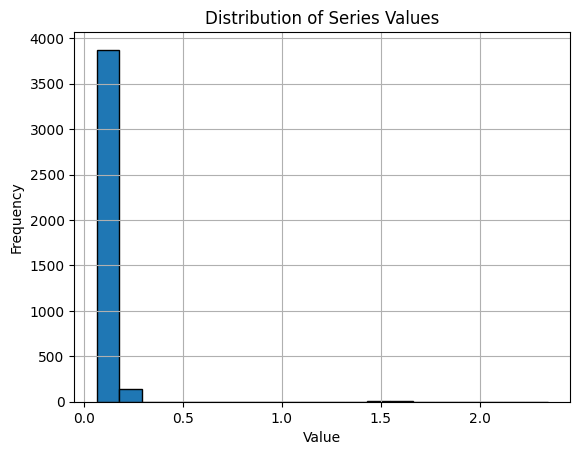

In [77]:
histogram(serie_cpu)

In [78]:
data = cpu_data.copy()
data.drop('is_anomaly' , axis = 1)
threshold_ad = ThresholdAD(high=0.2, low=0)
anomalies = threshold_ad.detect(serie_cpu)
L = anomalies['value'].values
T = convert(L)
data['is_anomaly'] = T

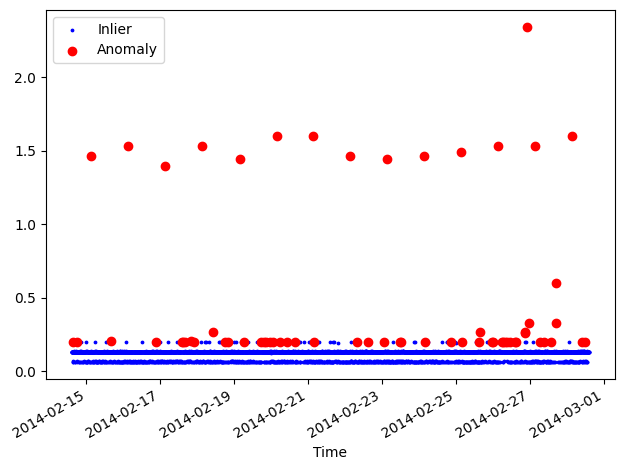

In [79]:
visualisation(data)

In [80]:
data_2 = cpu_data.copy()
data_2.drop('is_anomaly' , axis = 1)
quantile_ad = QuantileAD(high=0.99, low=0.01)
anomalies = quantile_ad.fit_detect(serie_cpu)
L_2 = anomalies['value'].values
T_2 = convert(L_2)
data_2['is_anomaly'] = T_2

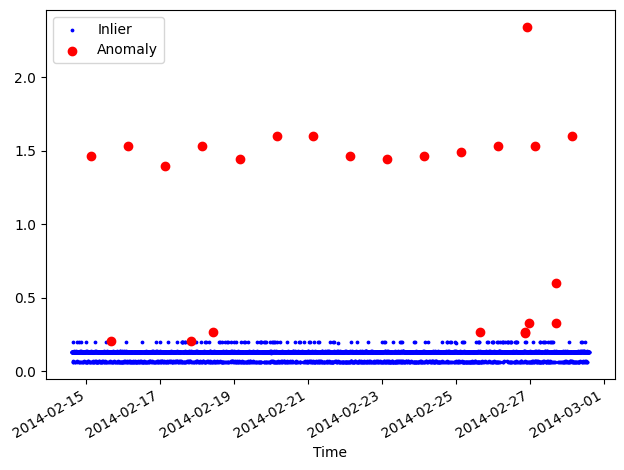

In [81]:
visualisation(data_2)

In [82]:
data_3 = cpu_data.copy()
data_3.drop('is_anomaly' , axis = 1)
iqr_ad = InterQuartileRangeAD(c=1.5)
anomalies = iqr_ad.fit_detect(serie_cpu)
L_3 = anomalies['value'].values
T_3 = convert(L_3)
data_3['is_anomaly'] = T_3

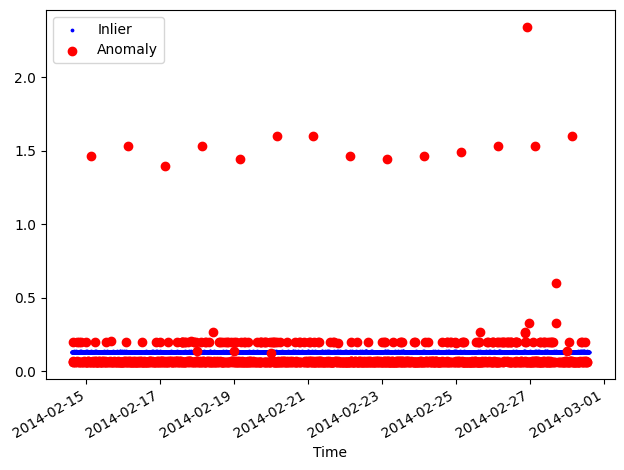

In [83]:
visualisation(data_3)

---

# PROPHET

In [84]:
cpu_prophet = datasetprophet(cpu_data)

In [85]:
model_prophet_cpu = Prophet(interval_width = 0.99 , yearly_seasonality = False , weekly_seasonality = False)
model_prophet_cpu.fit(cpu_prophet)


00:34:00 - cmdstanpy - INFO - Chain [1] start processing
00:34:01 - cmdstanpy - INFO - Chain [1] done processing


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


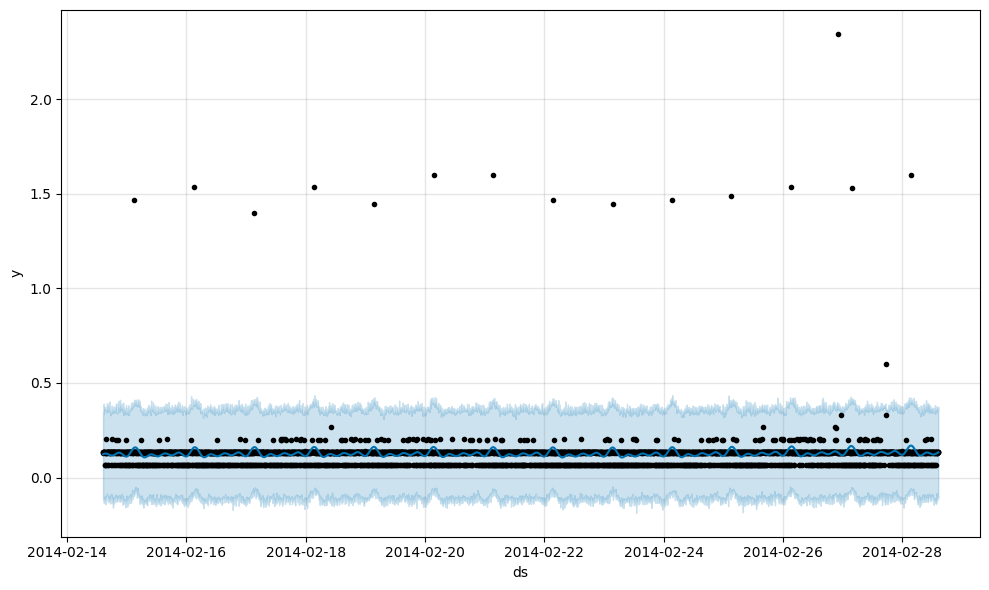

In [86]:
forecast(cpu_prophet,model_prophet_cpu)

In [87]:
performance_cpu = evaluation(cpu_prophet,model_prophet_cpu)

MAE is equal to  0.030995263362411055 
MAPE is equal to  0.29020802846280497 


In [88]:
performance_cpu['is_anomaly'] = cpu_data['is_anomaly'].values

In [89]:
confusion_metrics(performance_cpu)

Confusion Matrix:
True Negatives (TN): 2
False Positives (FP): 0
False Negatives (FN): 14
True Positives (TP): 4016
Recall (Sensitivity): 1.00
Specificity: 1.00


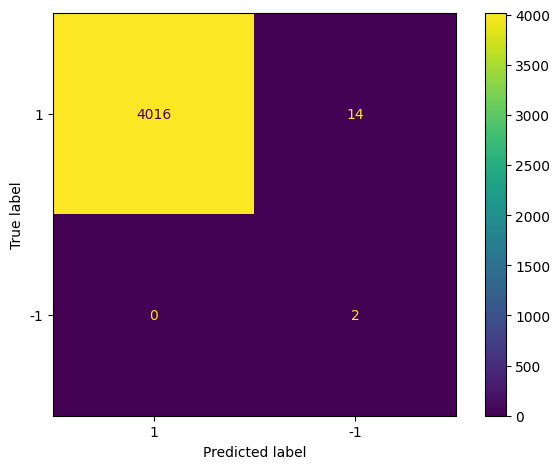

In [90]:
plot_confusion_matrix(performance_cpu)

---

---

---

# TWITTER DATA SET

In [91]:
twitter_data = importdataset("Twitter_volume_UPS.csv")

In [92]:
twitter_data = timestamp(twitter_data)

In [93]:
twitter_data  = label(twitter_data , anomalie__twitter)

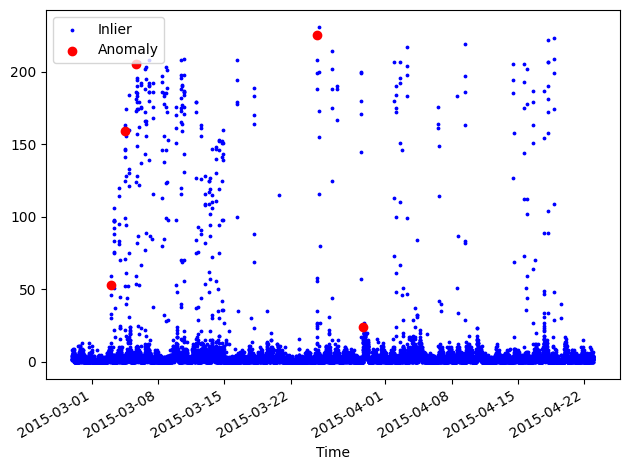

In [94]:
visualisation(twitter_data)

---

# LSTM 

In [95]:
new_df_1 = twitter_data.copy()
new_df_1 = new_df_1.set_index('timestamp')

In [96]:
serie_twitter = serie(twitter_data)
train_twitter , test_twitter = train_test(serie_twitter)

In [97]:
train_standard_twitter , test_standard_twitter = standard(train_twitter , test_twitter)

In [148]:
X_train_twitter, y_train_twitter = create_dataset(train_standard_twitter[['value']], train_standard_twitter.value, 24)
X_test_twitter, y_test_twitter = create_dataset(test_standard_twitter[['value']], test_standard_twitter.value, 24)

Epoch 1/10
424/424 [==============================] - 6s 12ms/step - loss: 0.2247 - val_loss: 0.2407
Epoch 2/10
424/424 [==============================] - 4s 11ms/step - loss: 0.2168 - val_loss: 0.2386
Epoch 3/10
424/424 [==============================] - 4s 10ms/step - loss: 0.2148 - val_loss: 0.2386
Epoch 4/10
424/424 [==============================] - 4s 11ms/step - loss: 0.2141 - val_loss: 0.2380
Epoch 5/10
424/424 [==============================] - 4s 10ms/step - loss: 0.2138 - val_loss: 0.2379
Epoch 6/10
424/424 [==============================] - 4s 10ms/step - loss: 0.2136 - val_loss: 0.2380
Epoch 7/10
424/424 [==============================] - 4s 10ms/step - loss: 0.2135 - val_loss: 0.2380
Epoch 8/10
424/424 [==============================] - 4s 11ms/step - loss: 0.2134 - val_loss: 0.2380
Epoch 9/10
424/424 [==============================] - 4s 11ms/step - loss: 0.2133 - val_loss: 0.2378
Epoch 10/10
424/424 [==============================] - 4s 11ms/step - loss: 0.2131 - val_lo

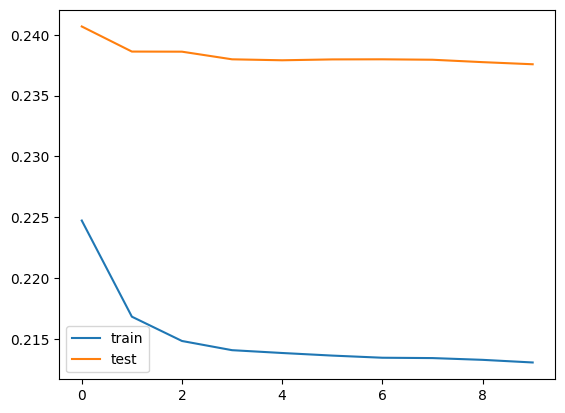

In [149]:
model_twitter = create_and_train_lstm_model(X_train_twitter, y_train_twitter, epochs=10, batch_size=32, validation_split=0.1, shuffle=False)
plt.plot(model_twitter[1].history['loss'], label='train')
plt.plot(model_twitter[1].history['val_loss'], label='test')
plt.legend()

25/25 [==============================] - 1s 4ms/step


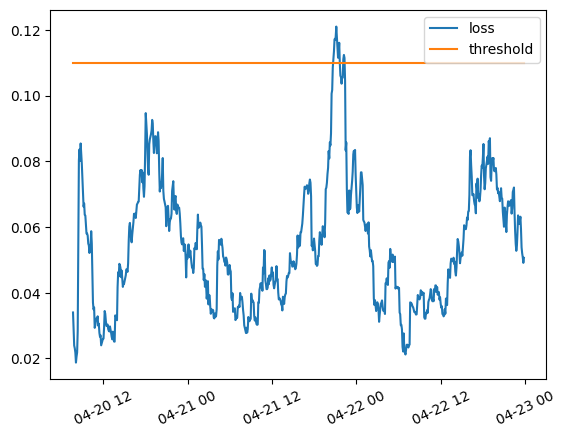

In [150]:
test_score_twitter = detect_anomalies(X_test_twitter, model_twitter[0], test_standard_twitter, 24, threshold=0.11)
plot_loss(test_score_twitter)

In [151]:
df_with_ground_truth_twitter = mark_ground_truth(test_score_twitter, anomalie__twitter)

Confusion Matrix:
True Negatives (TN): 756
False Positives (FP): 14
False Negatives (FN): 0
True Positives (TP): 0
Recall (Sensitivity): 0.00
Specificity: 0.98


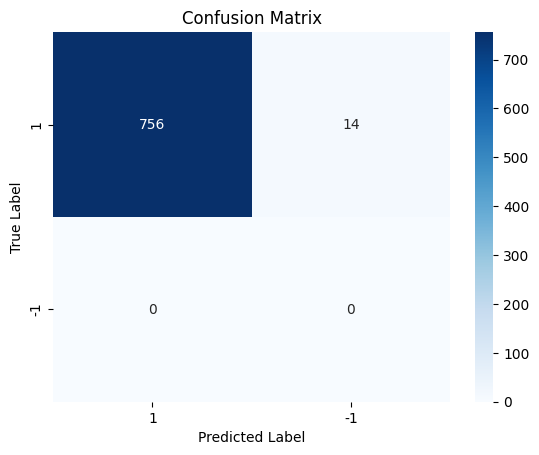

In [152]:
print_confusion_matrix_metrics_lm(df_with_ground_truth_twitter)

# MAD

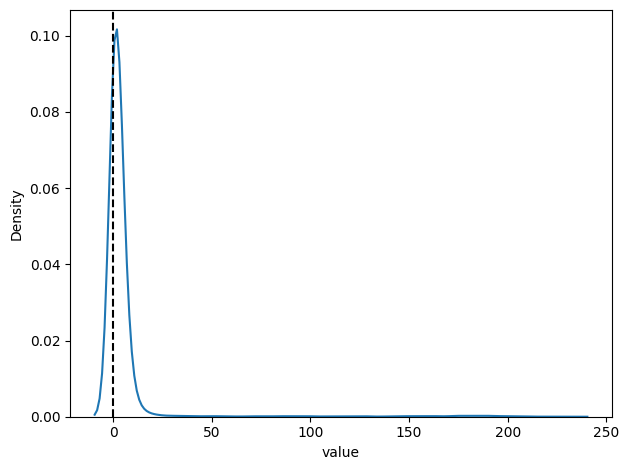

In [104]:
isnormal(twitter_data)

In [105]:
MAD_twitter_data_set =add_robust_z_score_column(twitter_data)

In [106]:
anomaly_predicted(MAD_twitter_data_set)

,timestamp,value,is_anomaly,z-score,anomaly_predicted
0,2015-02-26 21:42:53,2,1,0.00000,1
1,2015-02-26 21:47:53,2,1,0.00000,1
2,2015-02-26 21:52:53,4,1,0.67450,1
3,2015-02-26 21:57:53,3,1,0.33725,1
4,2015-02-26 22:02:53,5,1,1.01175,1
...,...,...,...,...,...
15861,2015-04-22 23:27:53,3,1,0.33725,1
15862,2015-04-22 23:32:53,2,1,0.00000,1
15863,2015-04-22 23:37:53,2,1,0.00000,1
15864,2015-04-22 23:42:53,3,1,0.33725,1


Confusion Matrix:
True Negatives (TN): 5
False Positives (FP): 0
False Negatives (FN): 609
True Positives (TP): 15252
Recall (Sensitivity): 0.96
Specificity: 1.00


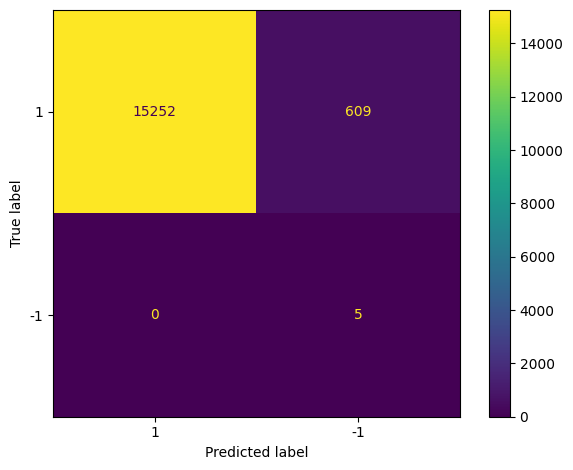

In [107]:
confusion_metrics(anomaly_predicted(MAD_twitter_data_set))
plot_confusion_matrix(anomaly_predicted(MAD_twitter_data_set))

---

# Isoltation forest

In [108]:
train_twitter , test_twitter = train_test_split(twitter_data, test_size=0.2, random_state=42)

Contamination level: 0.1
Confusion Matrix:
True Negatives (TN): 0
False Positives (FP): 0
False Negatives (FN): 299
True Positives (TP): 2875
Recall (Sensitivity): 0.91
Specificity: 0.00


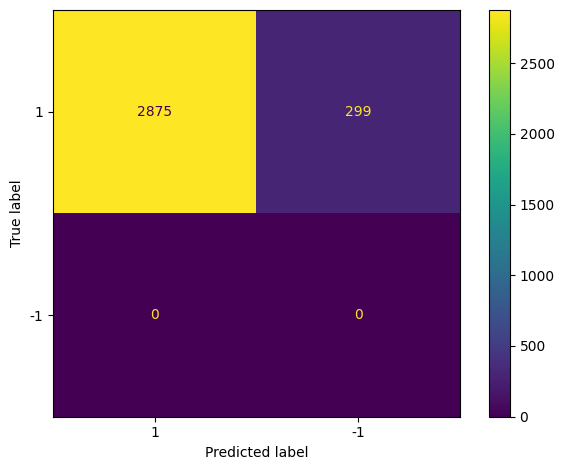

In [109]:
prediction_result_twitter = createisolation(train_twitter , test_twitter, 0.1)


print(f"Contamination level: {0.1}")
confusion_metrics_iso(test_twitter, prediction_result_twitter)
plot_confusion_matrix_iso(test_twitter, prediction_result_twitter)

---

# LOF

Contamination level: 0.5


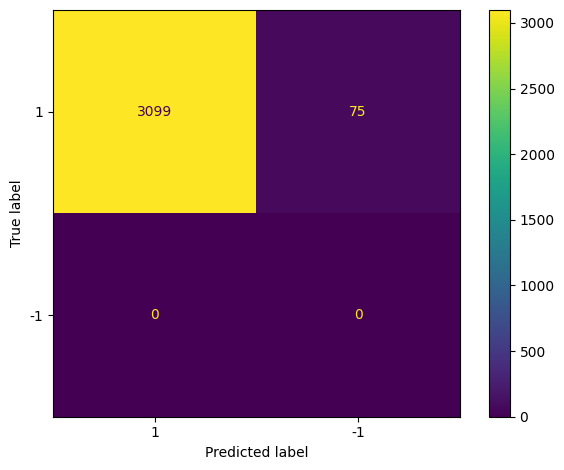

Confusion Matrix Metrics:
True Negatives (TN): 3099
False Positives (FP): 75
False Negatives (FN): 0
True Positives (TP): 0
Recall (Sensitivity): 0.00
Specificity: 0.98


In [112]:
i = 0.5

# Create isolation with the current contamination level
cm = compute_confusion_matrix_local(train_twitter , test_twitter  , i)

# Print metrics and plot confusion matrix
print(f"Contamination level: {i}")
display_confusion_matrix_local(cm)
print_confusion_matrix_metrics_local(cm)


---

# Prophet

In [122]:
twitter_prophet = datasetprophet(twitter_data)

In [124]:
model_prophet_twitter = Prophet(interval_width = 0.99 , yearly_seasonality = False , weekly_seasonality = False)
model_prophet_twitter.fit(twitter_prophet)


02:07:15 - cmdstanpy - INFO - Chain [1] start processing
02:07:16 - cmdstanpy - INFO - Chain [1] done processing


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


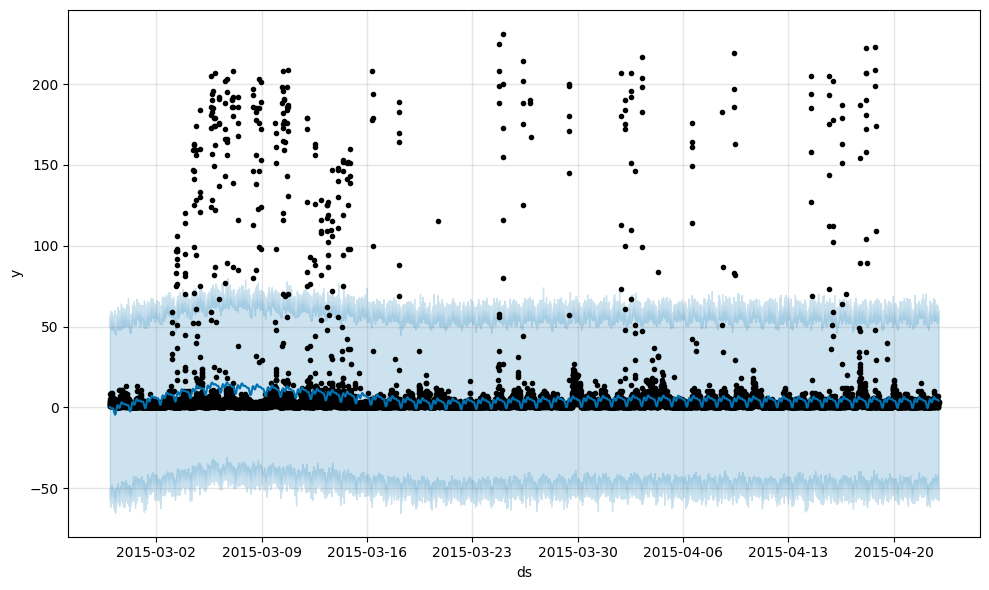

In [126]:
forecast(twitter_prophet,model_prophet_twitter)

In [127]:
performance_twitter = evaluation(twitter_prophet,model_prophet_twitter)

MAE is equal to  6.7865158176815035 
MAPE is equal to  5687881285476691.0 


In [128]:
performance_twitter['is_anomaly'] = twitter_data['is_anomaly'].values

In [129]:
confusion_metrics(performance_twitter)

Confusion Matrix:
True Negatives (TN): 3
False Positives (FP): 2
False Negatives (FN): 310
True Positives (TP): 15551
Recall (Sensitivity): 0.98
Specificity: 0.60


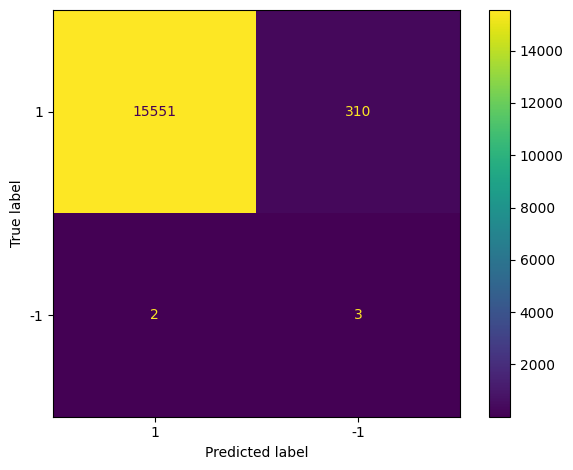

In [130]:
plot_confusion_matrix(performance_twitter)

---

---

---

# TAXI DATA SET

In [111]:
taxi_data = importdataset("nyc_taxi.csv")

In [112]:
taxi_data = timestamp(taxi_data)

In [172]:
taxi_data = label(taxi_data, anomalie_taxi)

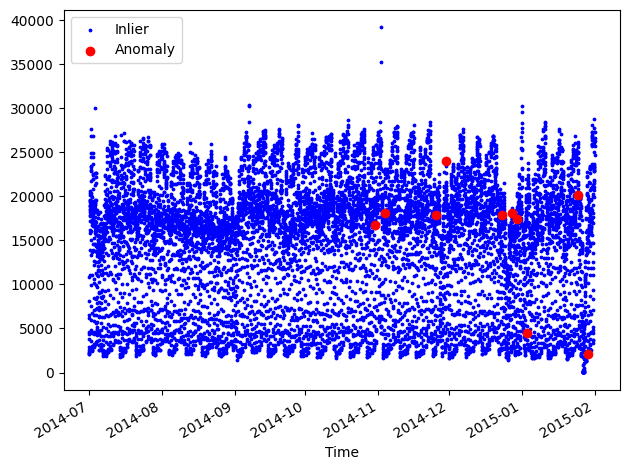

In [114]:
visualisation(taxi_data)

---

# LSTM

In [131]:
new_df_2 = taxi_data.copy()
new_df_2 = new_df_2.set_index('timestamp')


In [132]:
serie_taxi = serie(taxi_data)
train_taxi , test_taxi = train_test(serie_taxi)

In [133]:
train_standard_taxi , test_standard_taxi = standard(train_taxi , test_taxi)

In [134]:
X_train_taxi, y_train_taxi = create_dataset(train_standard_taxi[['value']], train_standard_taxi.value, 24)
X_test_taxi, y_test_taxi = create_dataset(test_standard_taxi[['value']], test_standard_taxi.value, 24)

Epoch 1/10
276/276 [==============================] - 5s 12ms/step - loss: 0.7726 - val_loss: 0.8222
Epoch 2/10
276/276 [==============================] - 3s 11ms/step - loss: 0.7622 - val_loss: 0.8242
Epoch 3/10
276/276 [==============================] - 3s 11ms/step - loss: 0.7581 - val_loss: 0.8241
Epoch 4/10
276/276 [==============================] - 3s 11ms/step - loss: 0.7560 - val_loss: 0.8227
Epoch 5/10
276/276 [==============================] - 3s 11ms/step - loss: 0.7535 - val_loss: 0.8191
Epoch 6/10
276/276 [==============================] - 3s 11ms/step - loss: 0.7516 - val_loss: 0.8179
Epoch 7/10
276/276 [==============================] - 3s 10ms/step - loss: 0.7498 - val_loss: 0.8127
Epoch 8/10
276/276 [==============================] - 3s 10ms/step - loss: 0.7486 - val_loss: 0.8094
Epoch 9/10
276/276 [==============================] - 3s 10ms/step - loss: 0.7480 - val_loss: 0.8053
Epoch 10/10
276/276 [==============================] - 3s 10ms/step - loss: 0.7474 - val_lo

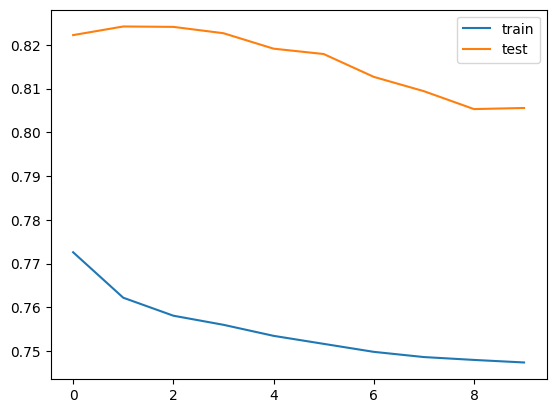

In [153]:
model_taxi = create_and_train_lstm_model(X_train_taxi, y_train_taxi, epochs=10, batch_size=32, validation_split=0.1, shuffle=False)
plt.plot(model_taxi[1].history['loss'], label='train')
plt.plot(model_taxi[1].history['val_loss'], label='test')
plt.legend()


 1/16 [>.............................] - ETA: 0s

16/16 [==============================] - 0s 6ms/step


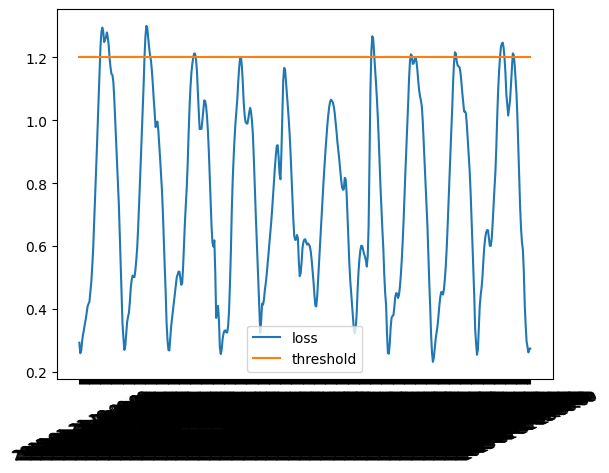

In [155]:
test_score_taxi = detect_anomalies(X_test_taxi, model_taxi[0], test_standard_taxi, 24, threshold=1.2)
plot_loss(test_score_taxi)

In [157]:
df_with_ground_truth_taxi = mark_ground_truth(test_score_taxi, anomalie_taxi)

Confusion Matrix:
True Negatives (TN): 455
False Positives (FP): 35
False Negatives (FN): 2
True Positives (TP): 0
Recall (Sensitivity): 0.00
Specificity: 0.93


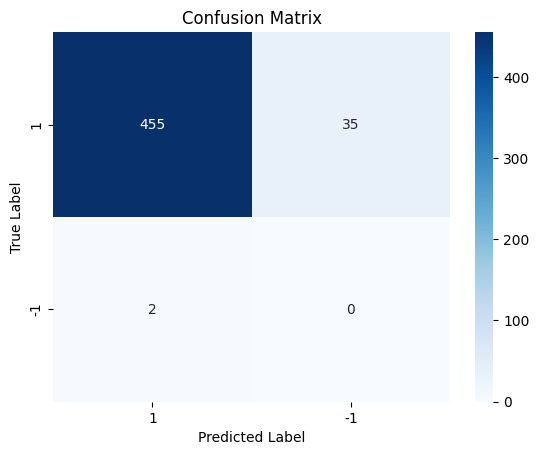

In [158]:
print_confusion_matrix_metrics_lm(df_with_ground_truth_taxi)

# MAD

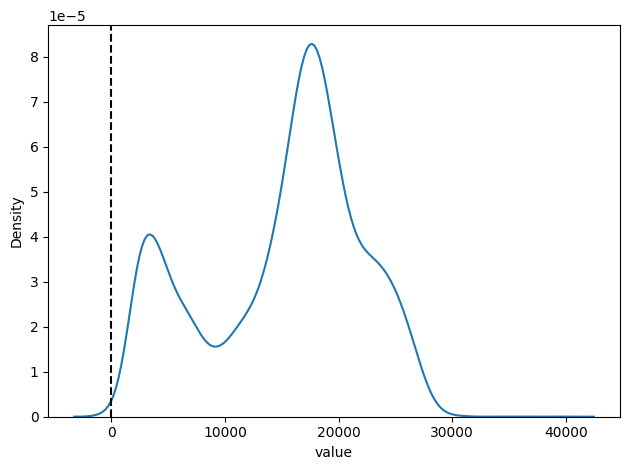

In [120]:
isnormal(taxi_data)

Confusion Matrix:
True Negatives (TN): 0
False Positives (FP): 10
False Negatives (FN): 1
True Positives (TP): 10309
Recall (Sensitivity): 1.00
Specificity: 0.00


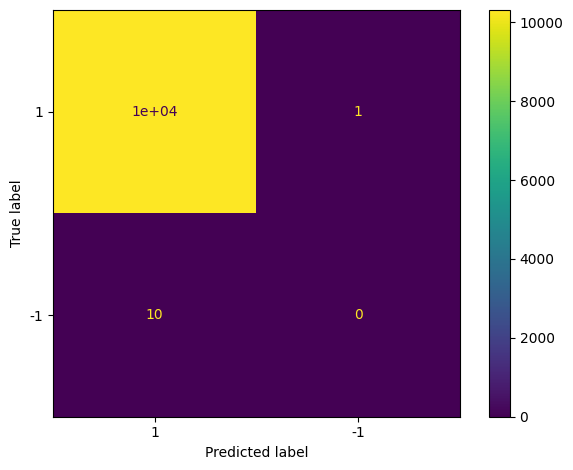

In [121]:
MAD_taxi_data_set =add_robust_z_score_column(taxi_data)
anomaly_predicted(MAD_taxi_data_set)
confusion_metrics(anomaly_predicted(MAD_taxi_data_set))
plot_confusion_matrix(anomaly_predicted(MAD_taxi_data_set))

# ISOLATION FOREST

---

In [177]:
train_taxi , test_taxi = train_test_split(taxi_data, test_size=0.2, random_state=42)

In [179]:
prediction_result_taxi = createisolation(train_taxi , test_taxi, 0.1)

In [180]:
print(f"Contamination level: {0.1}")
confusion_metrics_iso(test_taxi, prediction_result_taxi)

Contamination level: 0.1
Confusion Matrix:
True Negatives (TN): 0
False Positives (FP): 4
False Negatives (FN): 220
True Positives (TP): 1840
Recall (Sensitivity): 0.89
Specificity: 0.00


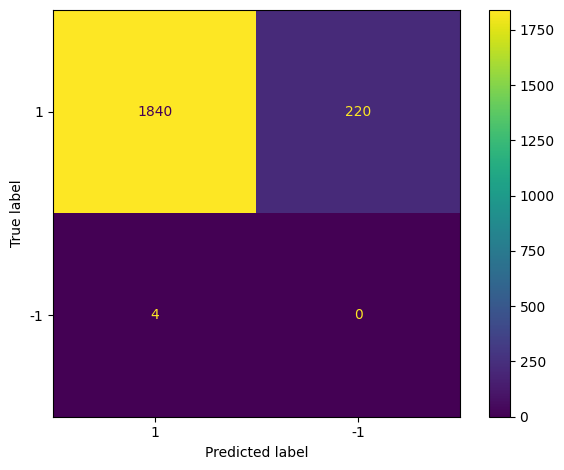

In [181]:
plot_confusion_matrix_iso(test_taxi, prediction_result_taxi)


---

# LOF

Contamination level: 0.1


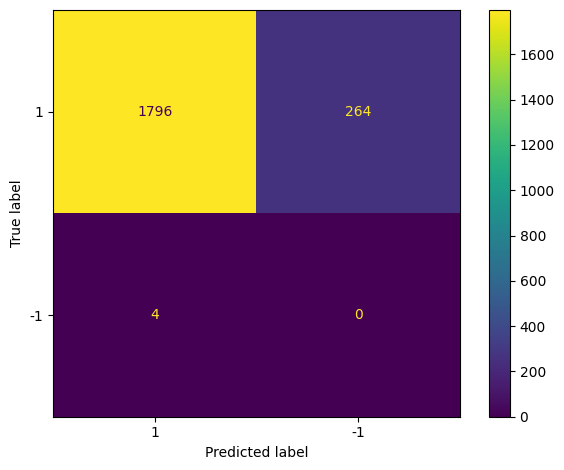

Confusion Matrix Metrics:
True Negatives (TN): 1796
False Positives (FP): 264
False Negatives (FN): 4
True Positives (TP): 0
Recall (Sensitivity): 0.00
Specificity: 0.87


In [184]:
i = 0.1

# Create isolation with the current contamination level
cm = compute_confusion_matrix_local(train_taxi , test_taxi  , i)

# Print metrics and plot confusion matrix
print(f"Contamination level: {i}")
display_confusion_matrix_local(cm)
print_confusion_matrix_metrics_local(cm)


---

# PROPHET

In [185]:
taxi_prophet = datasetprophet(taxi_data)

In [186]:
model_prophet_taxi = Prophet(interval_width = 0.99 , yearly_seasonality = False , weekly_seasonality = False)
model_prophet_taxi.fit(taxi_prophet)

03:07:14 - cmdstanpy - INFO - Chain [1] start processing
03:07:15 - cmdstanpy - INFO - Chain [1] done processing


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


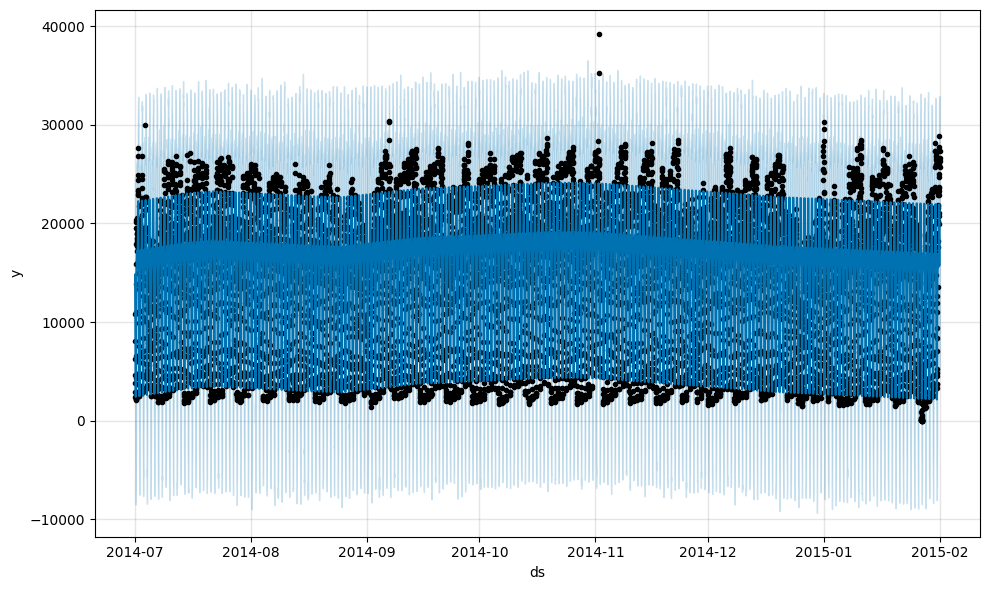

In [187]:
forecast(taxi_prophet,model_prophet_taxi)

In [205]:
def evaluation_1(df, model):
    # Ensure 'ds' in df is of type datetime
    df['ds'] = pd.to_datetime(df['ds'])

    # Generate forecast
    forecast = model.predict(df)

    # Ensure 'ds' in forecast is of type datetime
    forecast['ds'] = pd.to_datetime(forecast['ds'])

    # Merge the DataFrames
    performance = pd.merge(df, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

    # Calculate metrics
    performance_MAE = mean_absolute_error(performance['y'], performance['yhat'])
    performance_MAPE = mean_absolute_percentage_error(performance['y'], performance['yhat'])
    performance['anomaly_predicted'] = performance.apply(lambda rows : -1 if ((rows.y <rows.yhat_lower)  | (rows.y > rows.yhat_upper) ) else 1 , axis =1)
    print(f"performance_MAE is {performance_MAE }")
    print(f"performance_MAE is {performance_MAPE }")

    # Return or print your performance metrics
    return performance


In [206]:
performance_taxi = evaluation_1(taxi_prophet,model_prophet_taxi)

performance_MAE is 3062.942128006431
performance_MAE is 0.63294170956469


In [207]:
performance_taxi['is_anomaly'] = taxi_data['is_anomaly'].values

Confusion Matrix:
True Negatives (TN): 0
False Positives (FP): 10
False Negatives (FN): 191
True Positives (TP): 10119
Recall (Sensitivity): 0.98
Specificity: 0.00


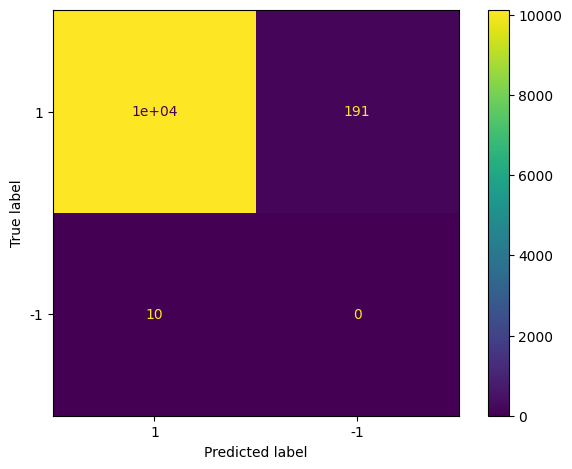

In [208]:
confusion_metrics(performance_taxi)
plot_confusion_matrix(performance_taxi)

---

---

---

# TRAVEL DATA SET

In [229]:
travel_data = importdataset("TravelTime_451.csv")

In [228]:
travel_data = timestamp(travel_data)

In [230]:
travel_data = label(travel_data, anomalie_traval)

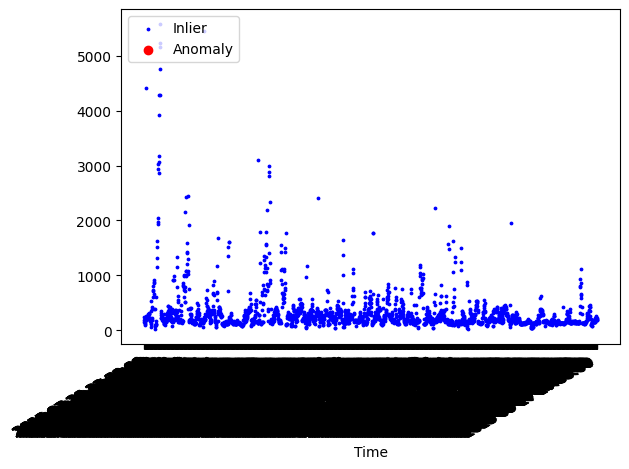

In [231]:
visualisation(travel_data)

---

# LSTM

In [232]:
new_df_3 = travel_data.copy()
new_df_3 = new_df_3.set_index('timestamp')

In [233]:
serie_travel = serie(travel_data)
train_travel , test_travel = train_test(serie_travel)

In [234]:
train_standard_travel , test_standard_travel = standard(train_travel , test_travel)

In [235]:
X_train_travel, y_train_travel = create_dataset(train_standard_travel[['value']], train_standard_travel.value, 24)
X_test_travel, y_test_travel = create_dataset(test_standard_travel[['value']], test_standard_travel.value, 24)

Epoch 1/10
58/58 [==============================] - 2s 17ms/step - loss: 0.4429 - val_loss: 0.1181
Epoch 2/10
58/58 [==============================] - 1s 13ms/step - loss: 0.4274 - val_loss: 0.1127
Epoch 3/10
58/58 [==============================] - 1s 14ms/step - loss: 0.4251 - val_loss: 0.1118
Epoch 4/10
58/58 [==============================] - 1s 11ms/step - loss: 0.4245 - val_loss: 0.1234
Epoch 5/10
58/58 [==============================] - 1s 10ms/step - loss: 0.4236 - val_loss: 0.1263
Epoch 6/10
58/58 [==============================] - 1s 11ms/step - loss: 0.4235 - val_loss: 0.1350
Epoch 7/10
58/58 [==============================] - 1s 11ms/step - loss: 0.4223 - val_loss: 0.1347
Epoch 8/10
58/58 [==============================] - 1s 11ms/step - loss: 0.4221 - val_loss: 0.1365
Epoch 9/10
58/58 [==============================] - 1s 11ms/step - loss: 0.4218 - val_loss: 0.1320
Epoch 10/10
58/58 [==============================] - 1s 11ms/step - loss: 0.4207 - val_loss: 0.1307


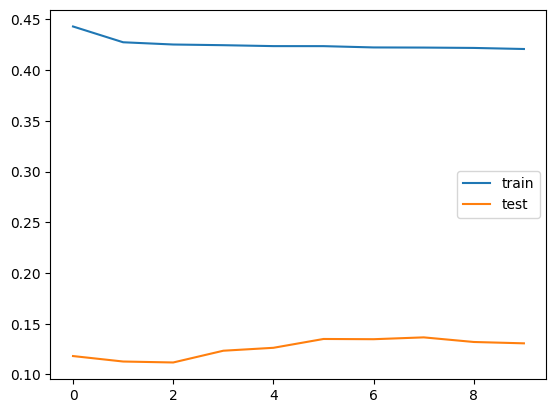

In [236]:
model_travel = create_and_train_lstm_model(X_train_travel, y_train_travel, epochs=10, batch_size=32, validation_split=0.1, shuffle=False)
plt.plot(model_travel[1].history['loss'], label='train')
plt.plot(model_travel[1].history['val_loss'], label='test')
plt.legend()

3/3 [==============================] - 0s 4ms/step


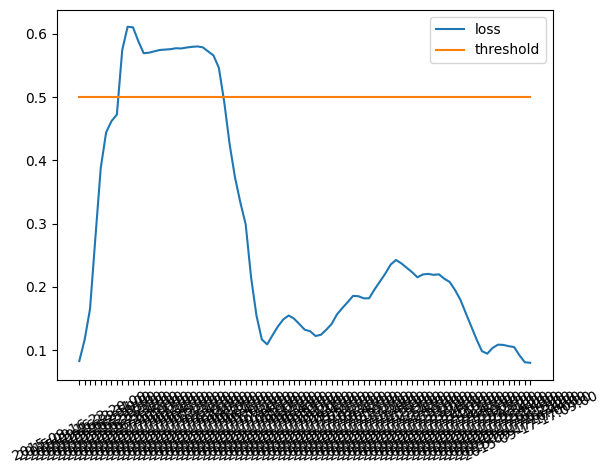

In [237]:
test_score_travel = detect_anomalies(X_test_travel, model_travel[0], test_standard_travel, 24, threshold=0.5)
plot_loss(test_score_travel)

Confusion Matrix:
True Negatives (TN): 66
False Positives (FP): 19
False Negatives (FN): 0
True Positives (TP): 0
Recall (Sensitivity): 0.00
Specificity: 0.78


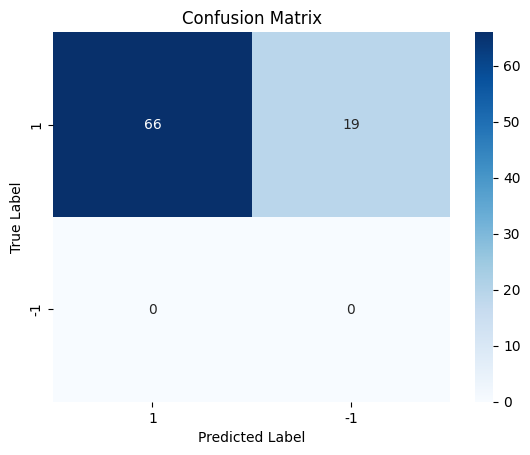

In [238]:
df_with_ground_truth_twitter = mark_ground_truth(test_score_travel, anomalie_traval)

print_confusion_matrix_metrics_lm(df_with_ground_truth_twitter)

---

# MAD

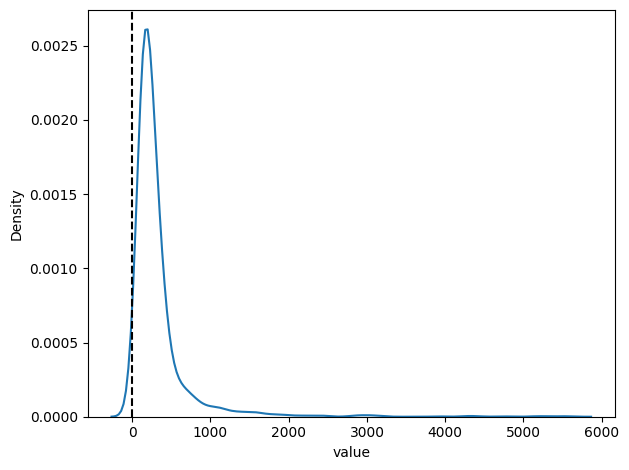

In [222]:
isnormal(travel_data)

In [239]:
MAD_travel_data_set =add_robust_z_score_column(travel_data)

In [240]:
anomaly_predicted(MAD_travel_data_set)

,timestamp,value,is_anomaly,z-score,anomaly_predicted
0,2015-07-28 11:56:00,248,1,0.404700,1
1,2015-07-28 12:06:00,178,1,-0.224833,1
2,2015-07-28 12:25:00,155,1,-0.431680,1
3,2015-07-28 13:56:00,121,1,-0.737453,1
4,2015-07-28 14:06:00,103,1,-0.899333,1
...,...,...,...,...,...
2157,2015-09-17 16:23:00,255,1,0.467653,1
2158,2015-09-17 16:34:00,189,1,-0.125907,1
2159,2015-09-17 16:44:00,193,1,-0.089933,1
2160,2015-09-17 17:00:00,216,1,0.116913,1


In [241]:
confusion_metrics(anomaly_predicted(MAD_travel_data_set))

Confusion Matrix:
True Negatives (TN): 0
False Positives (FP): 0
False Negatives (FN): 217
True Positives (TP): 1945
Recall (Sensitivity): 0.90
Specificity: 0.00


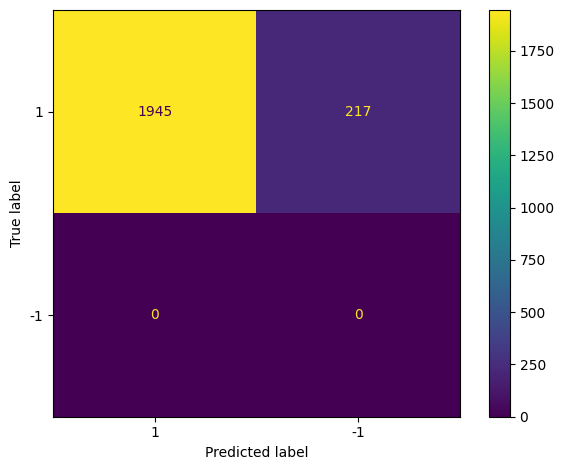

In [242]:
plot_confusion_matrix(anomaly_predicted(MAD_travel_data_set))

---

# ISOLATION FOREST

In [243]:
train_travel , test_travel = train_test_split(travel_data, test_size=0.2, random_state=42)

Contamination level: 0.1
Confusion Matrix:
True Negatives (TN): 0
False Positives (FP): 0
False Negatives (FN): 41
True Positives (TP): 392
Recall (Sensitivity): 0.91
Specificity: 0.00


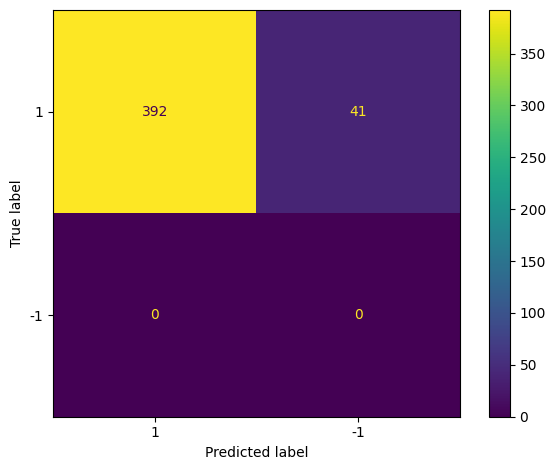

In [244]:
prediction_result_travel = createisolation(train_travel , test_travel, 0.1)


print(f"Contamination level: {0.1}")
confusion_metrics_iso(test_travel, prediction_result_travel)
plot_confusion_matrix_iso(test_travel, prediction_result_travel)

---

# LOF

Contamination level: 0.1


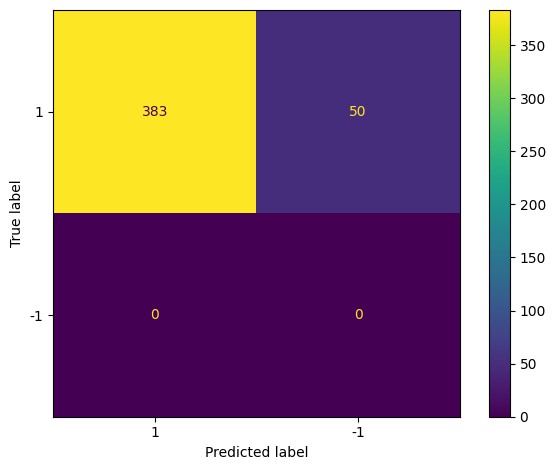

Confusion Matrix Metrics:
True Negatives (TN): 383
False Positives (FP): 50
False Negatives (FN): 0
True Positives (TP): 0
Recall (Sensitivity): 0.00
Specificity: 0.88


In [245]:
i = 0.1

# Create isolation with the current contamination level
cm = compute_confusion_matrix_local(train_travel , test_travel  , i)

# Print metrics and plot confusion matrix
print(f"Contamination level: {i}")
display_confusion_matrix_local(cm)
print_confusion_matrix_metrics_local(cm)


---

# Prophet

In [247]:
travel_prophet = datasetprophet(travel_data)

In [250]:
model_prophet_travel = Prophet(interval_width = 0.99 , yearly_seasonality = False , weekly_seasonality = False)

In [251]:
model_prophet_travel.fit(travel_prophet)

03:53:19 - cmdstanpy - INFO - Chain [1] start processing
03:53:20 - cmdstanpy - INFO - Chain [1] done processing


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


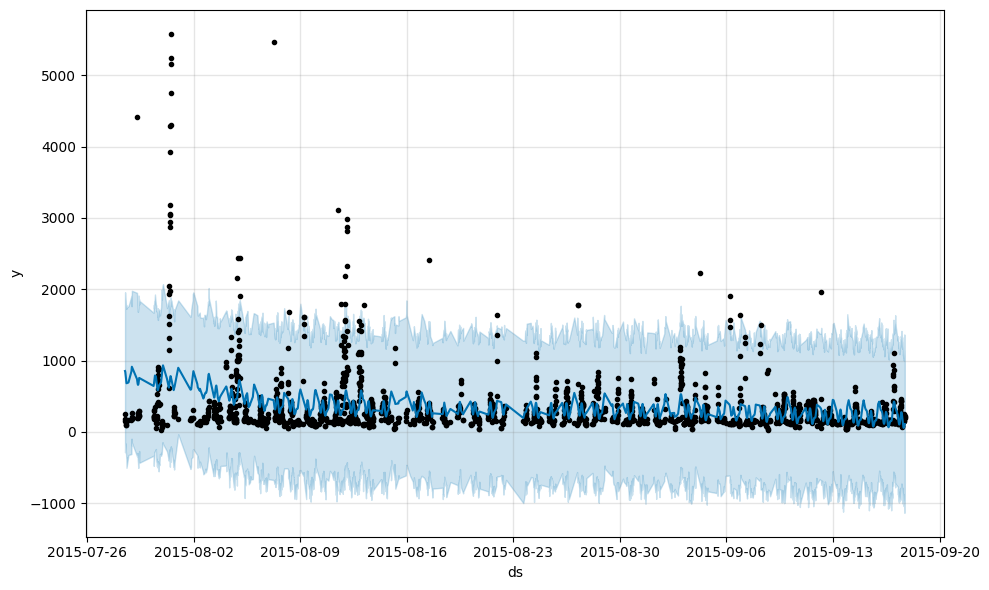

In [252]:
forecast(travel_prophet,model_prophet_travel)

In [253]:
performance_travel = evaluation_1(travel_prophet,model_prophet_travel)

performance_MAE is 211.3671501349471
performance_MAE is 0.9020265186654157


In [254]:
performance_travel['is_anomaly'] = travel_data['is_anomaly'].values

Confusion Matrix:
True Negatives (TN): 0
False Positives (FP): 0
False Negatives (FN): 49
True Positives (TP): 2113
Recall (Sensitivity): 0.98
Specificity: 0.00


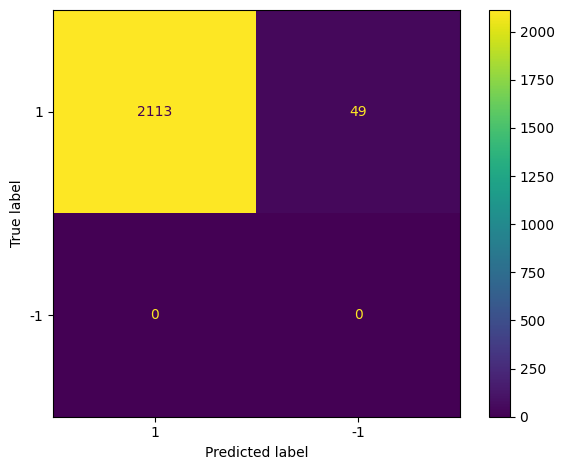

In [255]:
confusion_metrics(performance_travel)
plot_confusion_matrix(performance_travel)

---

----

---

# Ambiant data

---

In [257]:
ambiant_data = importdataset("ambient_temperature_system_failure.csv")

In [258]:
ambiant_data = timestamp(ambiant_data)

In [259]:
ambiant_data = label(ambiant_data, anomalies_ambiant)

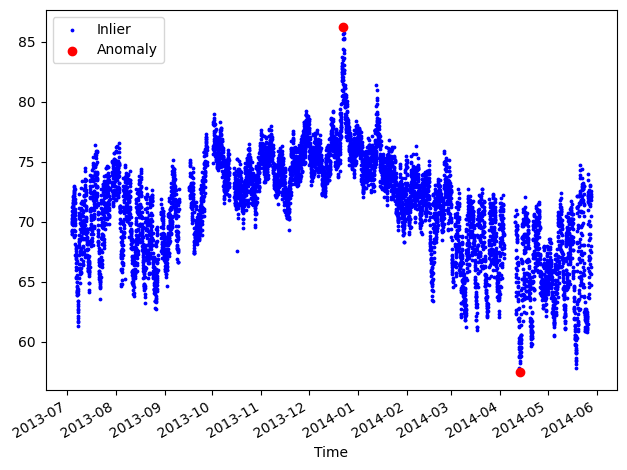

In [260]:
visualisation(ambiant_data)

---

# LSTM

---

In [262]:
new_df_4 = ambiant_data.copy()
new_df_4 = new_df_4.set_index('timestamp')

In [264]:
serie_ambiant = serie(ambiant_data)
train_ambiant , test_ambiant = train_test(serie_ambiant)

In [265]:
train_standard_ambiant , test_standard_ambiant = standard(train_ambiant , test_ambiant)
X_train_ambiant, y_train_ambiant = create_dataset(train_standard_ambiant[['value']], train_standard_ambiant.value, 24)
X_test_ambiant, y_test_ambiant  = create_dataset(test_standard_ambiant[['value']], test_standard_ambiant.value, 24)

In [267]:
model_ambiant = create_and_train_lstm_model(X_train_ambiant, y_train_ambiant, epochs=10, batch_size=32, validation_split=0.1, shuffle=False)

Epoch 1/10
194/194 [==============================] - 6s 17ms/step - loss: 0.3802 - val_loss: 0.4453
Epoch 2/10
194/194 [==============================] - 2s 12ms/step - loss: 0.3529 - val_loss: 0.4376
Epoch 3/10
194/194 [==============================] - 2s 11ms/step - loss: 0.3445 - val_loss: 0.4320
Epoch 4/10
194/194 [==============================] - 2s 11ms/step - loss: 0.3417 - val_loss: 0.4307
Epoch 5/10
194/194 [==============================] - 2s 11ms/step - loss: 0.3376 - val_loss: 0.4226
Epoch 6/10
194/194 [==============================] - 2s 10ms/step - loss: 0.3337 - val_loss: 0.4182
Epoch 7/10
194/194 [==============================] - 2s 11ms/step - loss: 0.3294 - val_loss: 0.4166
Epoch 8/10
194/194 [==============================] - 2s 11ms/step - loss: 0.3279 - val_loss: 0.4146
Epoch 9/10
194/194 [==============================] - 2s 11ms/step - loss: 0.3260 - val_loss: 0.4124
Epoch 10/10
194/194 [==============================] - 2s 11ms/step - loss: 0.3257 - val_lo

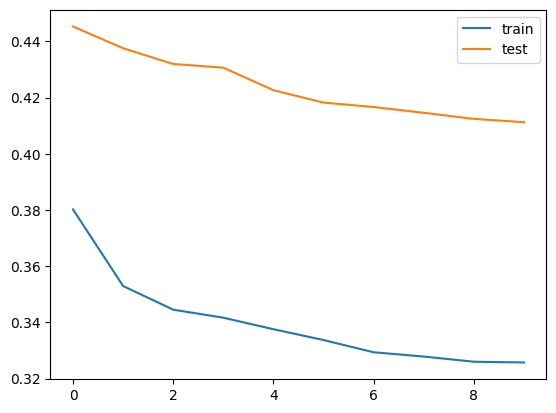

In [268]:
plt.plot(model_ambiant[1].history['loss'], label='train')
plt.plot(model_ambiant[1].history['val_loss'], label='test')
plt.legend()

 1/11 [=>............................] - ETA: 0s

11/11 [==============================] - 0s 3ms/step


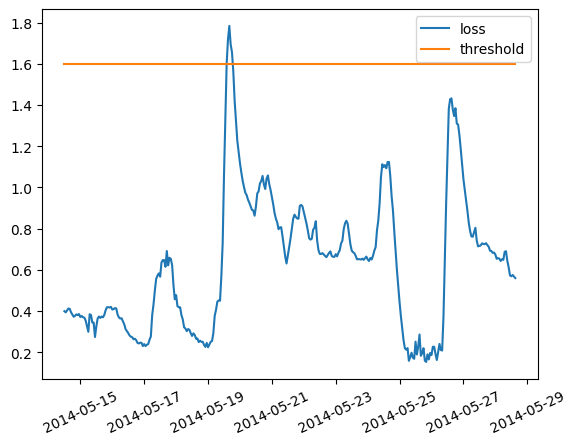

In [270]:
test_score_ambiant = detect_anomalies(X_test_ambiant, model_ambiant[0], test_standard_ambiant, 24, threshold=1.6)
plot_loss(test_score_ambiant)

In [271]:
df_with_ground_truth_ambiant = mark_ground_truth(test_score_ambiant, anomalies_ambiant)


Confusion Matrix:
True Negatives (TN): 335
False Positives (FP): 5
False Negatives (FN): 0
True Positives (TP): 0
Recall (Sensitivity): 0.00
Specificity: 0.99


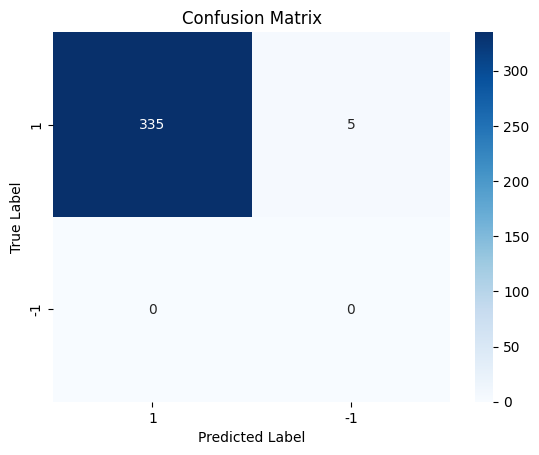

In [272]:
print_confusion_matrix_metrics_lm(df_with_ground_truth_ambiant)

---






# MAD

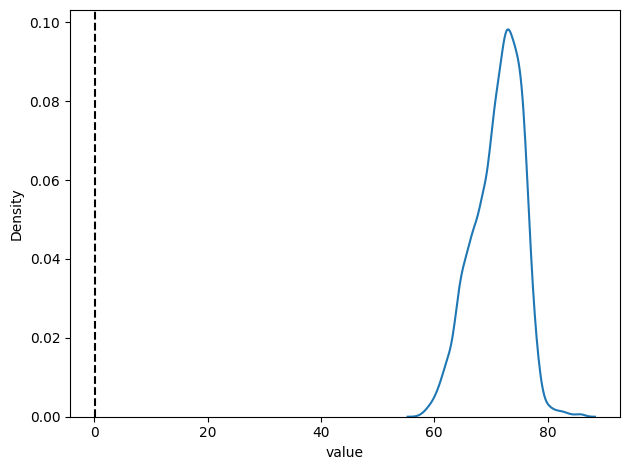

In [274]:
isnormal(ambiant_data)

In [275]:
MAD_ambiant_data_set =add_robust_z_score_column(ambiant_data)

Confusion Matrix:
True Negatives (TN): 0
False Positives (FP): 2
False Negatives (FN): 0
True Positives (TP): 7265
Recall (Sensitivity): 1.00
Specificity: 0.00


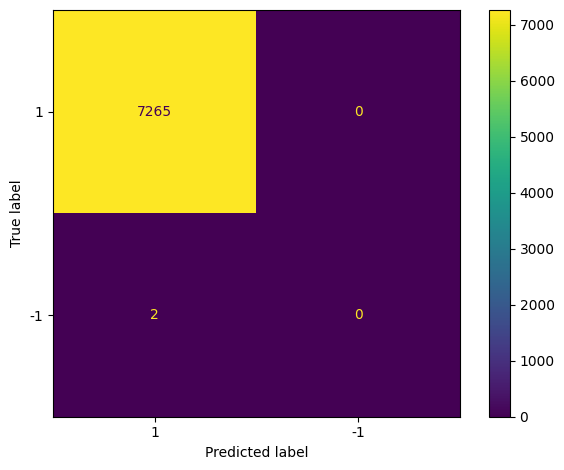

In [277]:
confusion_metrics(anomaly_predicted(MAD_ambiant_data_set))
plot_confusion_matrix(anomaly_predicted(MAD_ambiant_data_set))

---

# Isolation Forest

In [278]:
train_ambiant , test_ambiant = train_test_split(ambiant_data, test_size=0.2, random_state=42)

In [279]:
prediction_result_ambiant = createisolation(train_ambiant , test_ambiant, 0.1)

Contamination level: 0.1
Confusion Matrix:
True Negatives (TN): 1
False Positives (FP): 0
False Negatives (FN): 149
True Positives (TP): 1304
Recall (Sensitivity): 0.90
Specificity: 1.00


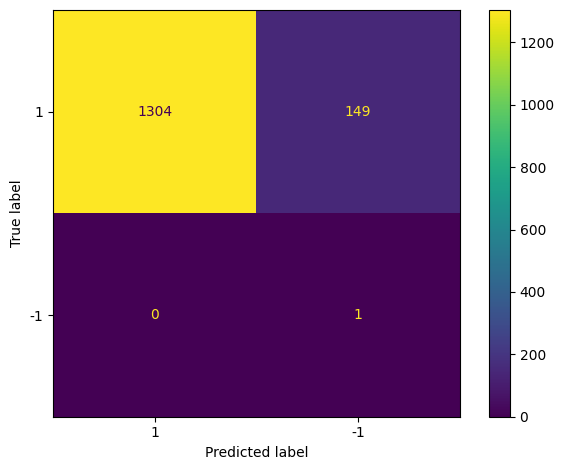

In [280]:
print(f"Contamination level: {0.1}")
confusion_metrics_iso( test_ambiant , prediction_result_ambiant)
plot_confusion_matrix_iso( test_ambiant , prediction_result_ambiant)

# LOF

Contamination level: 0.1


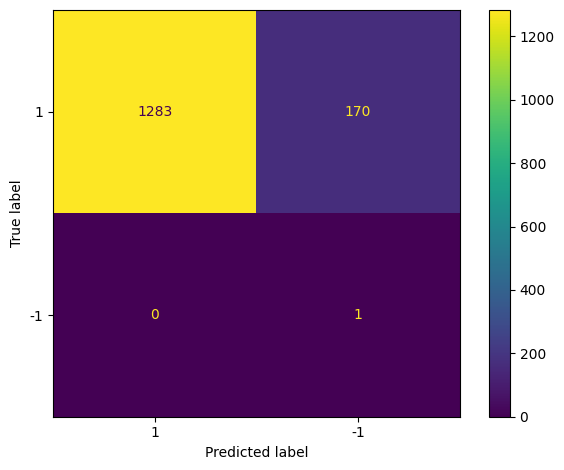

Confusion Matrix Metrics:
True Negatives (TN): 1283
False Positives (FP): 170
False Negatives (FN): 0
True Positives (TP): 1
Recall (Sensitivity): 1.00
Specificity: 0.88


In [281]:
i = 0.1

# Create isolation with the current contamination level
cm = compute_confusion_matrix_local(train_ambiant , test_ambiant  , i)

# Print metrics and plot confusion matrix
print(f"Contamination level: {i}")
display_confusion_matrix_local(cm)
print_confusion_matrix_metrics_local(cm)


---

# Prophet

In [285]:
ambiant_prophet = datasetprophet(ambiant_data)

In [286]:
model_prophet_ambiant = Prophet(interval_width = 0.99 , yearly_seasonality = False , weekly_seasonality = False)

In [287]:
model_prophet_ambiant.fit(ambiant_prophet)

04:27:47 - cmdstanpy - INFO - Chain [1] start processing
04:27:48 - cmdstanpy - INFO - Chain [1] done processing


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


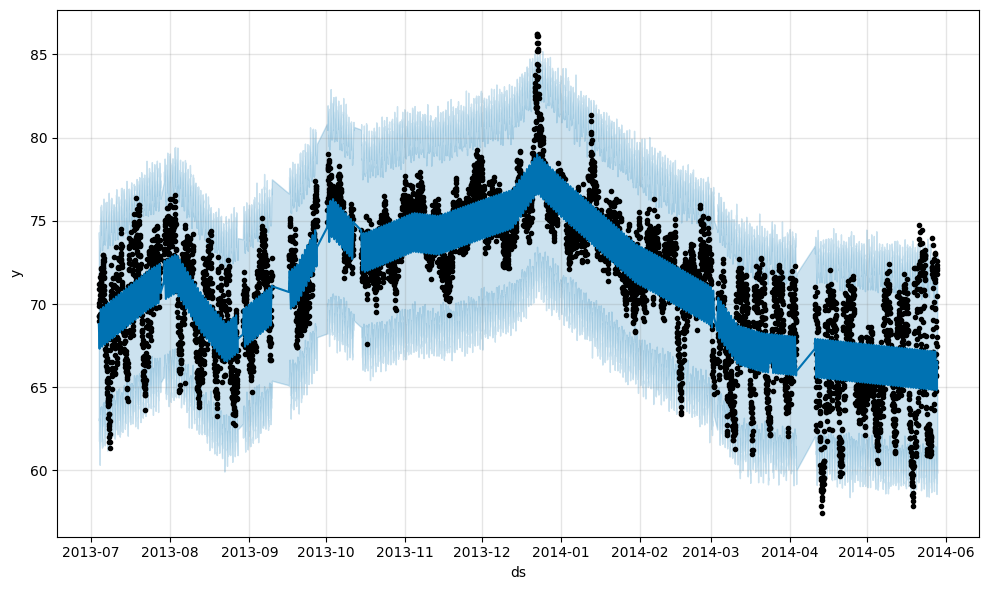

In [288]:
forecast(ambiant_prophet,model_prophet_ambiant)

In [290]:
performance_ambiant = evaluation_1(ambiant_prophet,model_prophet_ambiant)

performance_MAE is 1.805208118629272
performance_MAE is 0.025879329921175285


In [291]:
performance_ambiant['is_anomaly'] = ambiant_data['is_anomaly'].values

Confusion Matrix:
True Negatives (TN): 2
False Positives (FP): 0
False Negatives (FN): 151
True Positives (TP): 7114
Recall (Sensitivity): 0.98
Specificity: 1.00


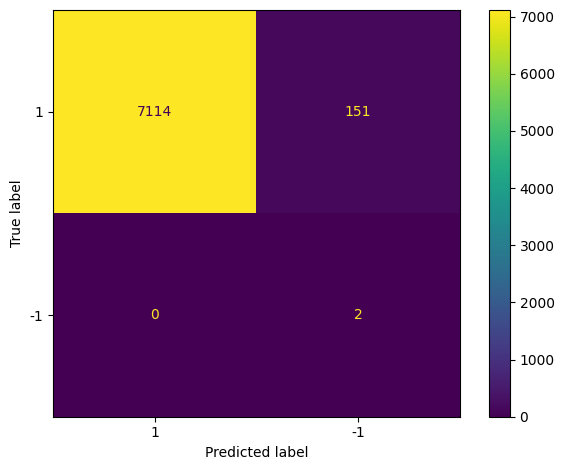

In [292]:
confusion_metrics(performance_ambiant)
plot_confusion_matrix(performance_ambiant)

---
---
---

# Machine Data

In [294]:
machine_data = importdataset("machine_temperature_system_failure.csv")

In [295]:
machine_data = timestamp(machine_data)

In [296]:
machine_data = label(machine_data, anomalie_machine)

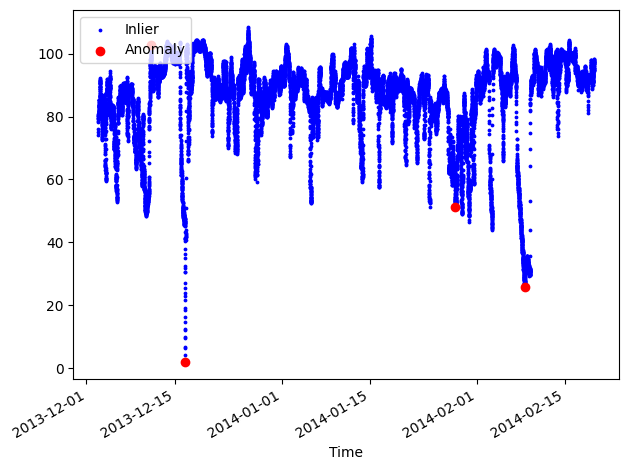

In [298]:
visualisation(machine_data)

---

# LSTM

In [299]:
new_df_5 = machine_data.copy()
new_df_5 = new_df_5.set_index('timestamp')

In [300]:
serie_machine = serie(machine_data)
train_machine , test_machine = train_test(serie_machine)

In [301]:
train_standard_machine , test_standard_machine = standard(train_machine , test_machine)
X_train_machine, y_train_machine, = create_dataset(train_standard_machine[['value']], train_standard_machine.value, 24)
X_test_machine, y_test_machine  = create_dataset(test_standard_machine[['value']], test_standard_machine.value, 24)

In [302]:
model_machine = create_and_train_lstm_model(X_train_machine, y_train_machine, epochs=10, batch_size=32, validation_split=0.1, shuffle=False)

Epoch 1/10
606/606 [==============================] - 10s 12ms/step - loss: 0.2071 - val_loss: 0.2073
Epoch 2/10
606/606 [==============================] - 6s 10ms/step - loss: 0.1740 - val_loss: 0.1924
Epoch 3/10
606/606 [==============================] - 8s 13ms/step - loss: 0.1706 - val_loss: 0.1580
Epoch 4/10
606/606 [==============================] - 7s 11ms/step - loss: 0.1668 - val_loss: 0.1677
Epoch 5/10
606/606 [==============================] - 6s 10ms/step - loss: 0.1658 - val_loss: 0.1615
Epoch 6/10
606/606 [==============================] - 6s 10ms/step - loss: 0.1652 - val_loss: 0.1455
Epoch 7/10
606/606 [==============================] - 6s 10ms/step - loss: 0.1659 - val_loss: 0.1422
Epoch 8/10
606/606 [==============================] - 6s 10ms/step - loss: 0.1661 - val_loss: 0.1637
Epoch 9/10
606/606 [==============================] - 6s 10ms/step - loss: 0.1660 - val_loss: 0.1442
Epoch 10/10
606/606 [==============================] - 7s 11ms/step - loss: 0.1658 - val_l

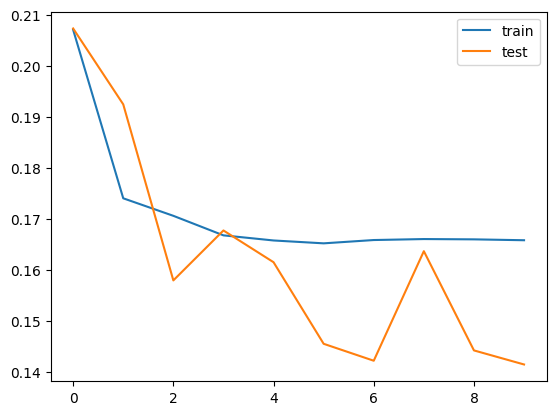

In [306]:
plt.plot(model_machine[1].history['loss'], label='train')
plt.plot(model_machine[1].history['val_loss'], label='test')
plt.legend()

35/35 [==============================] - 1s 3ms/step
Confusion Matrix:
True Negatives (TN): 1111
False Positives (FP): 0
False Negatives (FN): 0
True Positives (TP): 0
Recall (Sensitivity): 0.00
Specificity: 1.00


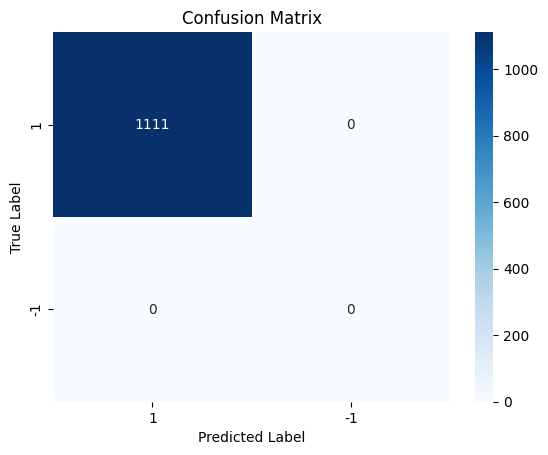

In [307]:
test_score_machine = detect_anomalies(X_test_machine, model_machine[0], test_standard_machine, 24, threshold=1.6)
df_with_ground_truth_machine = mark_ground_truth(test_score_machine, anomalie_machine)
print_confusion_matrix_metrics_lm(df_with_ground_truth_machine)

---

# MAD

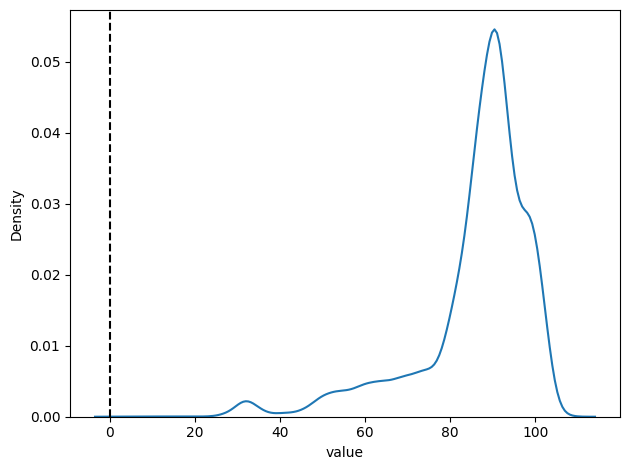

In [308]:
isnormal(machine_data)

Confusion Matrix:
True Negatives (TN): 3
False Positives (FP): 1
False Negatives (FN): 1745
True Positives (TP): 20946
Recall (Sensitivity): 0.92
Specificity: 0.75


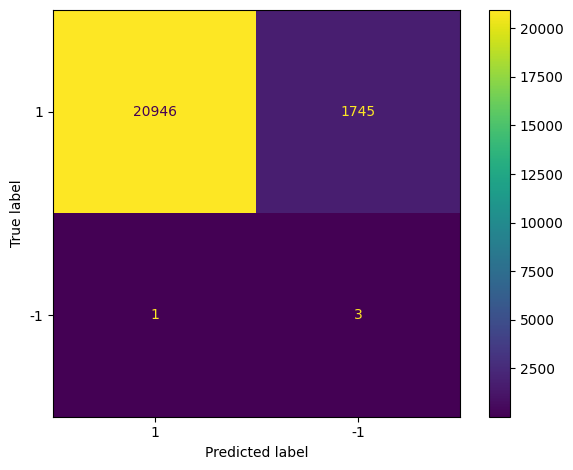

In [314]:
MAD_machine_data_set =add_robust_z_score_column(machine_data)
confusion_metrics(anomaly_predicted(MAD_machine_data_set))
plot_confusion_matrix(anomaly_predicted(MAD_machine_data_set))

---

# Isolation

Contamination level: 0.1
Confusion Matrix:
True Negatives (TN): 1
False Positives (FP): 0
False Negatives (FN): 461
True Positives (TP): 4077
Recall (Sensitivity): 0.90
Specificity: 1.00


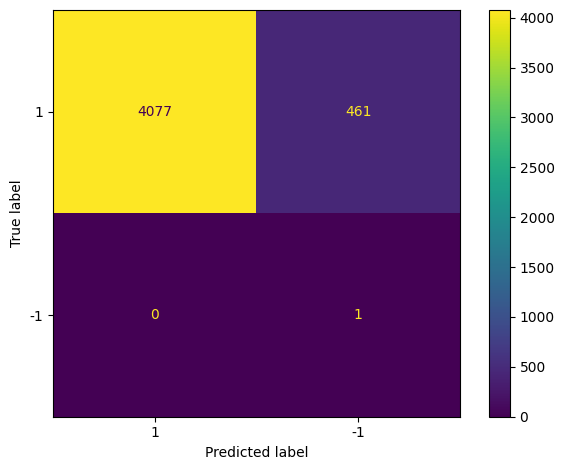

In [312]:
train_machine , test_machine  = train_test_split(machine_data, test_size=0.2, random_state=42)
prediction_result_machine = createisolation(train_machine  , test_machine , 0.1)
print(f"Contamination level: {0.1}")
confusion_metrics_iso( test_machine  , prediction_result_machine )
plot_confusion_matrix_iso( test_machine  , prediction_result_machine )

---

# LOF

Contamination level: 0.1


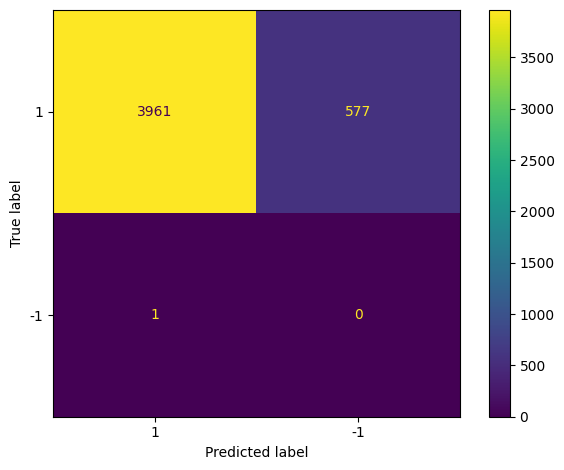

Confusion Matrix Metrics:
True Negatives (TN): 3961
False Positives (FP): 577
False Negatives (FN): 1
True Positives (TP): 0
Recall (Sensitivity): 0.00
Specificity: 0.87


In [313]:
i = 0.1

# Create isolation with the current contamination level
cm = compute_confusion_matrix_local(train_machine , test_machine  , i)

# Print metrics and plot confusion matrix
print(f"Contamination level: {i}")
display_confusion_matrix_local(cm)
print_confusion_matrix_metrics_local(cm)


---

In [320]:
machine_prophet = datasetprophet(machine_data)
model_prophet_machine = Prophet(interval_width = 0.99 , yearly_seasonality = False , weekly_seasonality = False)
model_prophet_machine.fit(machine_prophet)

05:37:22 - cmdstanpy - INFO - Chain [1] start processing
05:37:26 - cmdstanpy - INFO - Chain [1] done processing


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


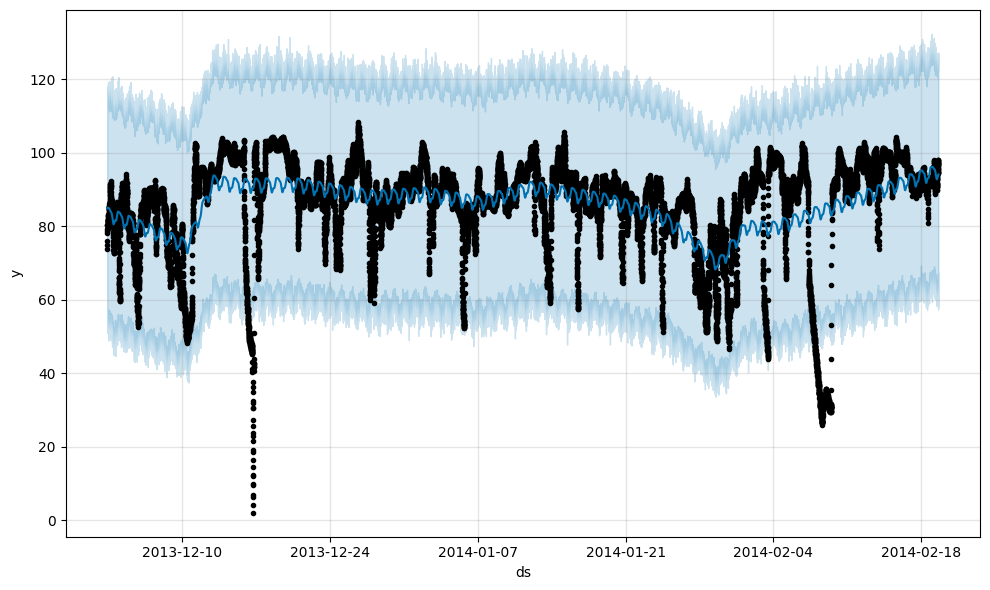

In [317]:

forecast(machine_prophet,model_prophet_machine)

In [326]:
performance_machine = evaluation_1(machine_prophet,model_prophet_machine)

performance_MAE is 8.119968889594627
performance_MAE is 0.12733453404501624
